This notebook is an exploration into applying Convolutional Neural Networks (CNNs) to the CIFAR-10 image data set. The main task presented in the briefing document was to employ a baseline CNN with 3 hidden layers and further explore different hyperparameters and network structures. All models that are built are evaluated using loss and accuracy metrics. Visualisation of these metrics is conducted using graph plots of (accuracy | loss) vs. epochs and confusion matrices.

The CIFAR-10 dataset we are working with is an image dataset that contains 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. This dataset is widely used in computer vision as it provides more complexity than MNIST (1 colour pixels, pictures of handwritten numbers) being Red-Green-Blue (RGB) pixel intensity, but is still beginner friendly.

Before attempting to undertake this task I conducted research into other people's work on this and other datasets within the computer vision field.

Links to relevant sources I have found and used can be found at the bottom of this page.

Like any notebook, first we import our relevant libraries, here we will be using PyTorch to build our CNN models instead of alternatives like Keras built over (TensorFlow | Theano).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import copy
import random
import time

%matplotlib inline
sn.set_style('whitegrid')

Here we set our device as our GPU to speed things up whilst running models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Setting random seeds' provides reproducibility when rerunning models whilst the same kernel is instantiated

In [ ]:
SEED = 221
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

Means and Standard Deviations caluclated here are for each of the Red-Green-Blue pixel intensities we are working with for the CIFAR10 dataset. They are all pretty similar which suggests we have a fairly uniform distribution of colour intensities.

In [ ]:
ROOT='.data'

train_data=datasets.CIFAR10(root=ROOT,train=True,download=True)

means=train_data.data.mean(axis=(0,1,2))/255 #0,1,2 are RGB, 255 is colour intensity range
stds=train_data.data.std(axis=(0,1,2))/255

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


Here are our different labels we are trying to predict.

In [ ]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

All of our labels are balanced meaning we have an equal number of training points for each class.

In [ ]:
class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Data Augmentation - it makes sense that RGB pictures of objects such as dogs or airplanes will have a variety of positioning differences such as slightly rotated (airplane flying up or down) or flipped (dog looking left or right). Data augmentation works to create more data by doing exactly this. Here we will increase the amount of relevant data by augmenting our data sets, that way we have more relevant data for our convolutional neural networks to learn on which should hopefully increase our prediction accuracy on testing set. Normalization here uses the RGB means and stds we found above.

In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5), #5degrees
                           transforms.RandomHorizontalFlip(0.5), #50% probability to flip
                           transforms.RandomCrop(32, padding=2), #output is 32-32 with 2 pixel padding on outside
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transforms = transforms.Compose([ #no augmentation on test
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

In [ ]:
train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Creating our validation set from our training set here we set it to be 10% of the training data (i.e., 5000 total images, 500 from each class). Our validation set gets transformed using our testing transformation as we want to use it as an indicator of how well our models will perform on test data.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO) #90%
n_valid_examples = len(train_data) - n_train_examples #10%

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [ ]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images) #number to print

    rows = int(np.sqrt(n_images)) #sort into grid
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10)) #image size to print

    for i in range(rows*cols): #get size rows * columns (no. images)

        ax = fig.add_subplot(rows, cols, i+1) #set up subplot grid size number images

        image = images[i] #get image at position i

        if normalize:
            image_min = image.min() #min values
            image_max = image.max() #max values
            image.clamp_(min=image_min, max=image_max) #clamps min / max to avoid saturation on colour intensities
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy()) #RGB pixels sent to cpu as numpy array
        ax.set_title(classes[labels[i]])
        ax.axis('off')

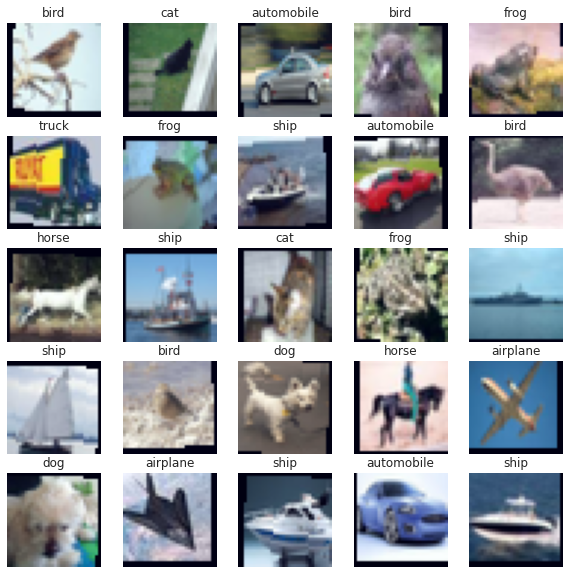

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes #10 classes

plot_images(images, labels, classes, normalize=True) #set normalize to true

**BaseModel**

Batch size of 64 is specified here as although increasing the batch size would reduce the amount of time required to train our CNNs, information could be lost when performing updates during backpropagation, smaller batch sizes work more effectively with smaller learning rates. Smaller learning rates and smaller batch sizes usually means more epochs are required to converge to our optimal loss.

In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True, #shuffle train data
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

This is our Baseline CNN model - it has an input Conv2d layer where 3 specifies that we are using RGB pixel images, 32 specifies our initial size. There are 3 hidden layers, two convolutional layers and one fully connected layer. Finally our output layer is a fully connected layer that takes 512 input size and reduces this to our output dimensions (in our case 10 as we have 10 image classes).

In [ ]:
class BaseModel(nn.Module):
  def __init__(self,output_dim):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1), #input layer
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,padding=1), #first hidden layer
        nn.MaxPool2d(2,2), #64 x 16 x 16
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1), #second hidden layer
        nn.MaxPool2d(2,2), #64 x 8 x 8, used to transform our linear layer
        nn.ReLU()
    )

    self.classifier=nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(64 * 8 * 8, 512), #third hidden layer
        nn.ReLU(),
        nn.Linear(512,output_dim) #output layer

    )

  def forward(self, x): #feed forward
    x=self.features(x)
    h=x.view(x.shape[0],-1)
    x=self.classifier(h)
    return x,h

Here we instantiate our baseline model with out output dimensions specified and count how many parameters it has using numel() - returning the number of elements in our input tensor. We should have more parameters than our training samples. More parameters means we can theoretically represent much more complicated functions, image detection is a difficult task so hopefully more parameters means our models can learn more features from the dataset.

In [ ]:
OUTPUT_DIM = 10

model1 = BaseModel(OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) #numel returns number of elements in input tensor, sum this for whole model parameters

print(f'The model has {count_parameters(model1):,} trainable parameters')

The model has 2,159,242 trainable parameters


2,159,242 seems large, but is small compared with current computer vision models.

Here we initialise the parameters for the different layers in our CNN models, Convolutional layers are initialised with weight initialisation Kaiming He which is used as it takes into account the non-linearity of activation functions which in our case is ReLU (and exploration into TanH).
   
Fully connected layer is initialisated using Xavier otherwise known as Glorot Normal, gain for Xavier is calculated using ReLU activation.

In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [ ]:
model1.apply(initialize_parameters)

BaseModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

The class below is used to find the optimal learning rate given a model, optimizer and critera to test against. The paradigm for the test was initially detailed by Leslie N. Smith in his paper 'Cyclical Learning Rates for Training Neural Networks'. Original implementation in PyTorch can be found here - https://github.com/davidtvs/pytorch-lr-finder.

It works as such: batches of data are fed to our model, learning rate is increased exponentially between two boundaires. The initial low learning rate is far too small to be optimal for our model but increases exponentially and allows our network to start converging. As the learning rate increases too much the network begins to diverge and the program is halted early.

As the losses are quite noisy, this implementation - https://github.com/bentrevett/pytorch-image-classification/blob/master/misc/4%20-%20VGG.ipynb uses the exponetially weighted average of the loss calculated to smooth the data. Model parameters are saved to disk when initialising the finder and reset before range_test function returns. Optimal learning rate is taken to be one order smaller than the value at which our loss curve begins to flatten.

Whilst conducting my research and having stumbled across this I started looking more into Leslie N. Smith's work. The paper he published was demonstrated for both CIFAR-10 and CIFAR-100 datasets. A very fast implementation to find lr for our model (the most important parameter) compared with gridsearch or randomized search methods. The paper is found below.

https://arxiv.org/abs/1506.01186

In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer #class so we instantiate our inputs
        self.model = model #cnn
        self.criterion = criterion #
        self.device = device #using gpu

        torch.save(model.state_dict(), 'init_params.pt') #we save the models parameters in local memory

    """Function tests images in batches using ExponenitalLR which Decays the learning rate of each
       parameter group by gamma every epoch. When last_epoch=-1, sets initial lr as lr.
       100 iterations, halted at learning rate 10"""
    def range_test(self, model, iterator, end_lr=10, num_iter=100, #included model to rerun class in same notebook
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter) #instantiate the scheduler

        iterator = IteratorWrapper(iterator) #iterator item contains images

        for iteration in range(num_iter): #100 iterations

            loss = self._train_batch(iterator) #train batch is back propagation

            lrs.append(lr_scheduler.get_last_lr()[0]) #keep a state of the lr

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1] #loss is smoothed

            if loss < best_loss: #update best loss
                best_loss = loss

            losses.append(loss) #append to array

            if loss > diverge_th * best_loss: #stop trial when loss is greater than diverge threshold * loss = 5 * best_loss
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt')) #trial finished, load parameters of the model with best loss to system state dictionary 

        return lrs, losses

    def _train_batch(self, iterator): #function is called upon in our range test it is a training function that does backprop

        self.model.train() #train model

        self.optimizer.zero_grad() #set gradient of optimizer adam to 0

        x, y = iterator.get_batch() #collect batch of images from iterator

        x = x.to(self.device) #send to device
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
        loss = self.criterion(y_pred, y) #measure loss prediction / actual
        loss.backward() #backprop i.e., compute gradient
        self.optimizer.step() #gradient descent
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch) #access parent, initialise optimizer adam and last epoch shown

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self): #iterate through images
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

Here our optimizer is Adam, we start our initial learning rate at 0.0000001 and finish at 10. We are expecting our optimal value to be within these bounds. Our loss criterion is set to CrossEntropy which is typical for computer vision classification tasks.

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model1.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss() #calculates number of bits required to represent average event from one distribution compared to another distribution

model1 = model1.to(device) #send everything to gpu
criterion = criterion.to(device)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model1, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model1, train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5): #skip start and end as they contain useless info

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

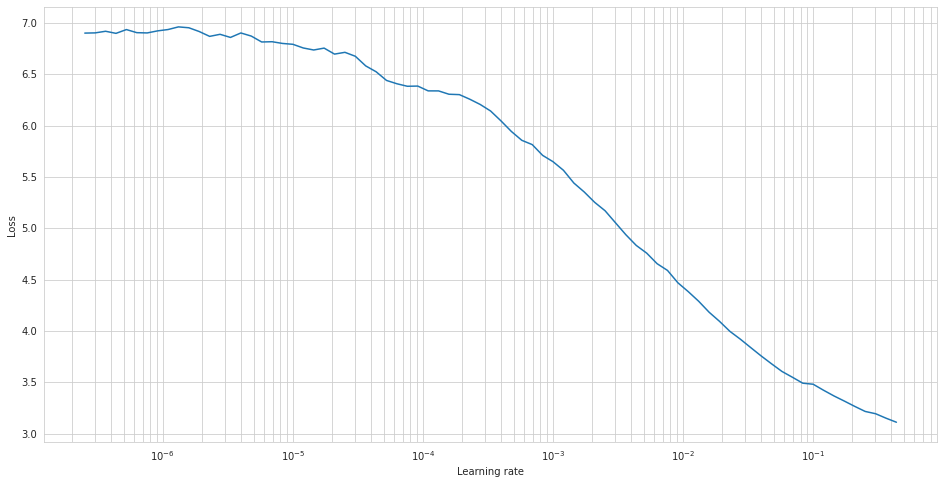

In [ ]:
plot_lr_finder(lrs, losses)

It looks like the loss curve starts to flatten at 10^-1 so we will use lr = one order smaller than this.

In [ ]:
FOUND_LR = 1e-2

optimizer = optim.Adam(model1.parameters(), lr=FOUND_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True) #return max value
    correct = top_pred.eq(y.view_as(top_pred)).sum() #correct equals to our actual label viewed in same size summed
    acc = correct.float() / y.shape[0]
    return acc

Backpropagation methods for training and validation/test sets

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() #start with 0 gradient

        y_pred, _ = model(x) #predict from model using x - the data in our iterator

        loss = criterion(y_pred, y) #loss is actual label and prediction

        acc = calculate_accuracy(y_pred, y) #accuracy between label and prediction

        loss.backward() #backprop - compute gradient (chain rule)

        optimizer.step() #gradient descent

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)
     
            #were not doing backprop on val/test set as were not using them to learn just predict

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Function times how long each epoch runs for

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses1=[] #plotting arrays
trainaccuracies1=[]
vallosses1=[]
valaccuracies1=[]

#tqdm uses trange to assess epoch completion as they run
for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic() #start timer for epoch

  train_loss, train_acc = train(model1, train_iterator, optimizer, criterion, device) #function defined above returns loss and accuracy

  valid_loss, valid_acc= evaluate(model1, valid_iterator, criterion, device) #function above returns loss and accuracy

  trainlosses1.append(np.double(train_loss)) #append losses / accuracies to array for plotting
  trainaccuracies1.append(np.double(train_acc*100))
  vallosses1.append(np.double(valid_loss))
  valaccuracies1.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model1.state_dict(), 'model1.pt') #best valid_loss gets parameters saved into our state_dict (python dictionary)

  end_time = time.monotonic() #finish timer for epoch

  epoch_mins, epoch_secs = epoch_time(start_time, end_time) #collect timings from our timer

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 2.724 | Train Acc: 31.45%
	 Val. Loss: 1.624 |  Val. Acc: 40.53%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.642 | Train Acc: 40.04%
	 Val. Loss: 1.560 |  Val. Acc: 45.29%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.500 | Train Acc: 46.15%
	 Val. Loss: 1.406 |  Val. Acc: 48.24%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.367 | Train Acc: 50.80%
	 Val. Loss: 1.173 |  Val. Acc: 57.81%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.287 | Train Acc: 54.67%
	 Val. Loss: 1.072 |  Val. Acc: 61.06%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.253 | Train Acc: 56.28%
	 Val. Loss: 1.050 |  Val. Acc: 61.73%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.234 | Train Acc: 57.41%
	 Val. Loss: 1.024 |  Val. Acc: 64.50%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.209 | Train Acc: 58.40%
	 Val. Loss: 1.027 |  Val. Acc: 64.26%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.210 | Train Acc: 58.42%
	 Val. Loss: 0.990 |  Val. Acc: 65.72%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 1.199 | Train Acc: 59.37%
	 Val. Loss: 0.998 |  Val. Acc: 65.74%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 22s
	Train Loss: 1.211 | Train Acc: 59.10%
	 Val. Loss: 1.011 |  Val. Acc: 65.35%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 22s
	Train Loss: 1.181 | Train Acc: 60.07%
	 Val. Loss: 1.014 |  Val. Acc: 65.66%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 23s
	Train Loss: 1.167 | Train Acc: 60.68%
	 Val. Loss: 0.986 |  Val. Acc: 65.64%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 22s
	Train Loss: 1.165 | Train Acc: 61.12%
	 Val. Loss: 0.987 |  Val. Acc: 66.36%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 23s
	Train Loss: 1.157 | Train Acc: 61.25%
	 Val. Loss: 0.972 |  Val. Acc: 66.46%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 22s
	Train Loss: 1.150 | Train Acc: 61.47%
	 Val. Loss: 0.932 |  Val. Acc: 69.11%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 22s
	Train Loss: 1.137 | Train Acc: 62.34%
	 Val. Loss: 0.991 |  Val. Acc: 66.44%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 23s
	Train Loss: 1.132 | Train Acc: 61.99%
	 Val. Loss: 0.954 |  Val. Acc: 67.82%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 22s
	Train Loss: 1.138 | Train Acc: 62.39%
	 Val. Loss: 0.896 |  Val. Acc: 70.02%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 22s
	Train Loss: 1.142 | Train Acc: 62.14%
	 Val. Loss: 0.946 |  Val. Acc: 67.66%


No sign of overfitting which is most likely due to our dropout, but we will return to this case later.

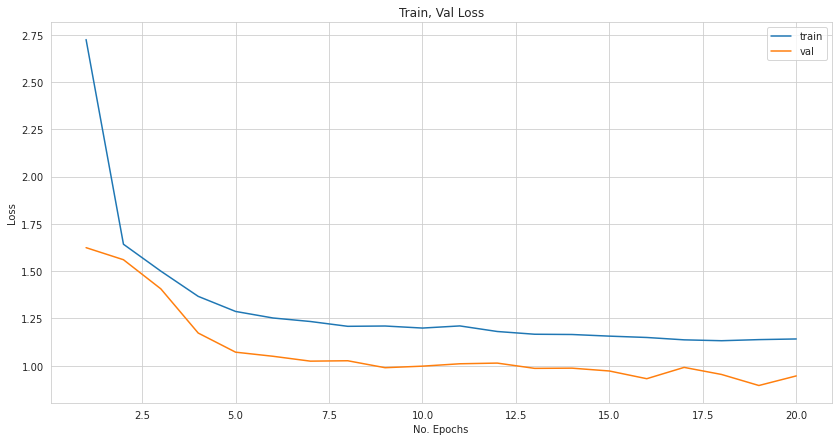

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses1,label='train')
plt.plot(x,vallosses1,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

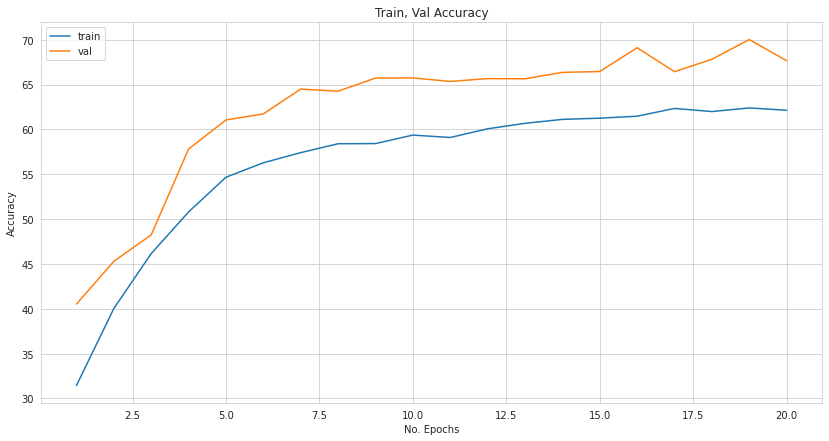

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies1,label='train')
plt.plot(x,valaccuracies1,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

In [ ]:
model1.load_state_dict(torch.load('model1.pt'))

test_loss, test_acc = evaluate(model1, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.914 | Test Acc: 70.07%


In [ ]:
def get_predictions(model, iterator, device):

    model.eval() #eval used here on test

    images = [] #our images
    labels = [] #class labels
    probs = [] #probabilities

    with torch.no_grad(): #reduce memory consumption as were not using .backward()

        for (x, y) in iterator: #images labels

            x = x.to(device) #send our data to gpu

            y_pred, _ = model(x) #pre 

            y_prob = F.softmax(y_pred, dim=-1) #functional softmax along dimension -1 used to re-scale between [0,1], all values in tensor add to one

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0) #concatenation
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model1, test_iterator, device) #got our data now need to collect and plot

pred_labels = torch.argmax(probs, 1) #argmax for predictions using our probabilties

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

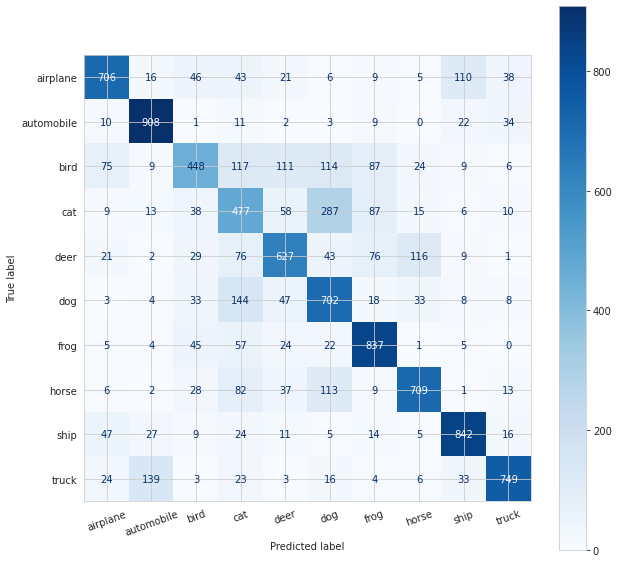

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

Our model performed worst on our class bird, there were many instances where it predicted our actual birds as being - cats, deer, dogs, frogs. I'm not sure if these classes share much in terms of feature repesentation, maybe birds are just difficult classes to ascertain features for. On the other hand, Truck was high in terms of prediction and was mostly only confused with automobiles. This makes sense as these two classes would share common features.

Now lets introduce some different hyperparameters into our baseline model and see how it fairs with the same network structure. First we are going to explore batch size and see its effect compared with our base model.

**Batch Size 128**

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE) #pin_memory=True

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

The model has 2,159,242 trainable parameters


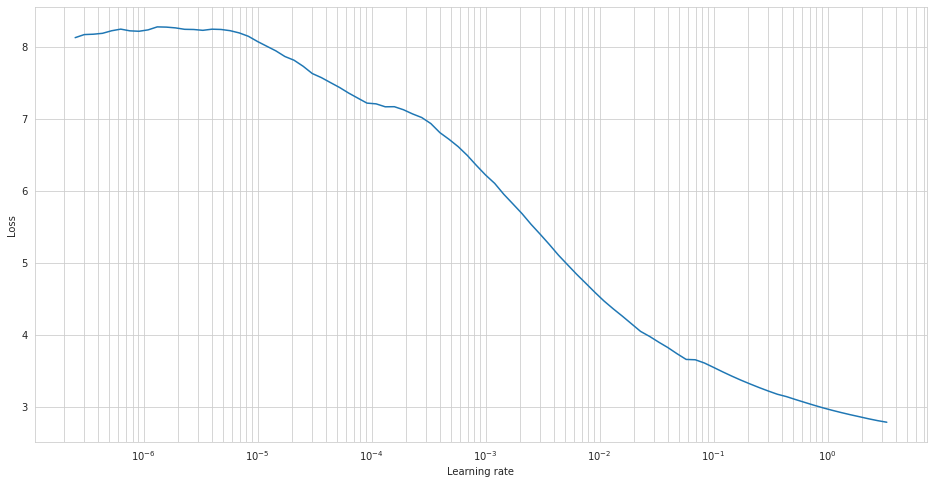

In [ ]:
OUTPUT_DIM = 10

model2 = BaseModel(OUTPUT_DIM) #we're using basemodel architecture with a different batch size

print(f'The model has {count_parameters(model2):,} trainable parameters')

model2.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model2.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model2 = model2.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model2, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model2,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

Looks like the loss curve is flattening at 10^-1 again.

In [ ]:
FOUND_LR = 1e-2

optimizer = optim.Adam(model2.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses2=[]
trainaccuracies2=[]
vallosses2=[]
valaccuracies2=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model2, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model2, valid_iterator, criterion, device)

  trainlosses2.append(np.double(train_loss))
  trainaccuracies2.append(np.double(train_acc*100))
  vallosses2.append(np.double(valid_loss))
  valaccuracies2.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model2.state_dict(), 'model2.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 4.468 | Train Acc: 29.21%
	 Val. Loss: 1.599 |  Val. Acc: 41.60%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.595 | Train Acc: 41.56%
	 Val. Loss: 1.417 |  Val. Acc: 48.28%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.483 | Train Acc: 46.16%
	 Val. Loss: 1.217 |  Val. Acc: 55.55%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.370 | Train Acc: 50.85%
	 Val. Loss: 1.168 |  Val. Acc: 57.66%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.288 | Train Acc: 54.46%
	 Val. Loss: 1.040 |  Val. Acc: 63.61%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.221 | Train Acc: 57.47%
	 Val. Loss: 1.027 |  Val. Acc: 63.57%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 1.156 | Train Acc: 59.99%
	 Val. Loss: 1.004 |  Val. Acc: 64.59%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 1.093 | Train Acc: 62.39%
	 Val. Loss: 0.874 |  Val. Acc: 69.67%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 1.054 | Train Acc: 63.81%
	 Val. Loss: 0.995 |  Val. Acc: 65.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 1.039 | Train Acc: 64.33%
	 Val. Loss: 0.849 |  Val. Acc: 70.21%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 21s
	Train Loss: 1.002 | Train Acc: 65.41%
	 Val. Loss: 0.909 |  Val. Acc: 68.87%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 21s
	Train Loss: 0.982 | Train Acc: 66.42%
	 Val. Loss: 0.811 |  Val. Acc: 72.17%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 22s
	Train Loss: 0.969 | Train Acc: 67.30%
	 Val. Loss: 0.845 |  Val. Acc: 70.68%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 22s
	Train Loss: 0.974 | Train Acc: 66.98%
	 Val. Loss: 0.817 |  Val. Acc: 72.09%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 21s
	Train Loss: 0.955 | Train Acc: 67.60%
	 Val. Loss: 0.814 |  Val. Acc: 72.09%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 22s
	Train Loss: 0.950 | Train Acc: 67.82%
	 Val. Loss: 0.779 |  Val. Acc: 73.05%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 21s
	Train Loss: 0.956 | Train Acc: 67.98%
	 Val. Loss: 0.855 |  Val. Acc: 71.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 24s
	Train Loss: 0.943 | Train Acc: 68.48%
	 Val. Loss: 0.770 |  Val. Acc: 73.71%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 22s
	Train Loss: 0.930 | Train Acc: 68.58%
	 Val. Loss: 0.792 |  Val. Acc: 73.44%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 21s
	Train Loss: 0.938 | Train Acc: 68.56%
	 Val. Loss: 0.784 |  Val. Acc: 73.09%


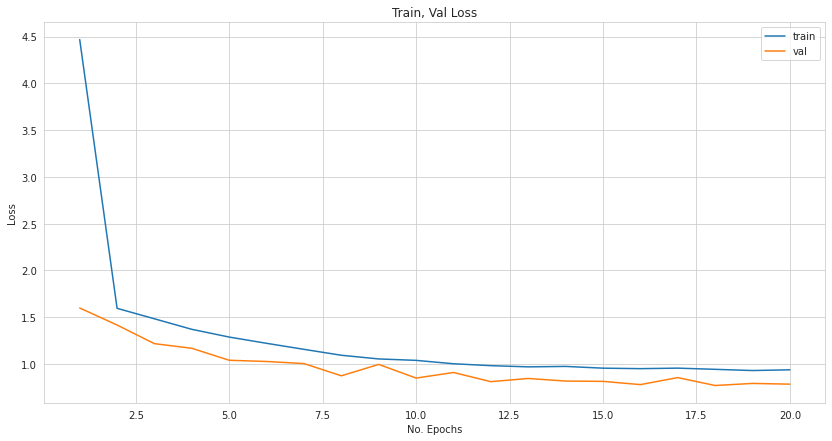

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses2,label='train')
plt.plot(x,vallosses2,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

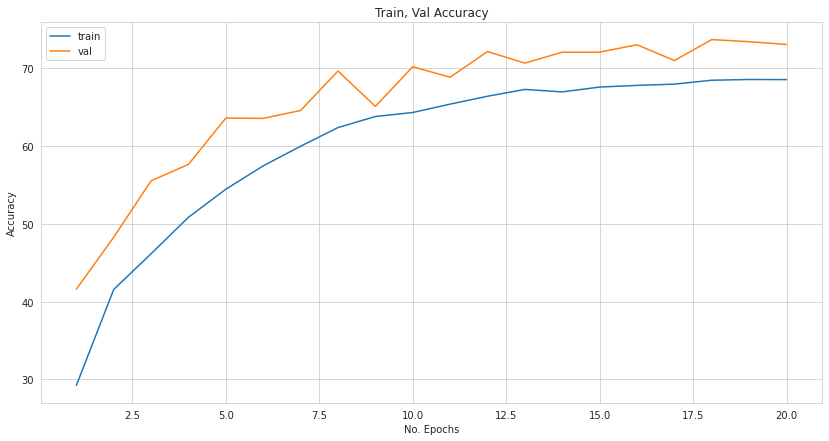

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies2,label='train')
plt.plot(x,valaccuracies2,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

No overfitting there, and it looks like increasing the batch size has improved our models loss / accuracy, lets take a look at its actual predictions.

In [ ]:
model2.load_state_dict(torch.load('model2.pt'))

test_loss, test_acc = evaluate(model2, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.789 | Test Acc: 73.71%


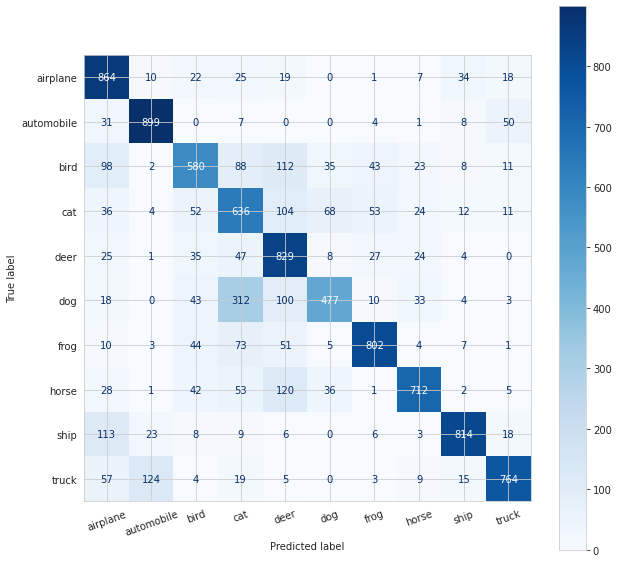

In [ ]:
images, labels, probs = get_predictions(model2, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Model appears to have improved on its bird predictions but has started confusing dogs as being cats. This is a particular class that I would assume share similar features and so our models may struggle to differentiate between them.

**Batch Size 256**

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE) #pin_memory=True

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

The model has 2,159,242 trainable parameters


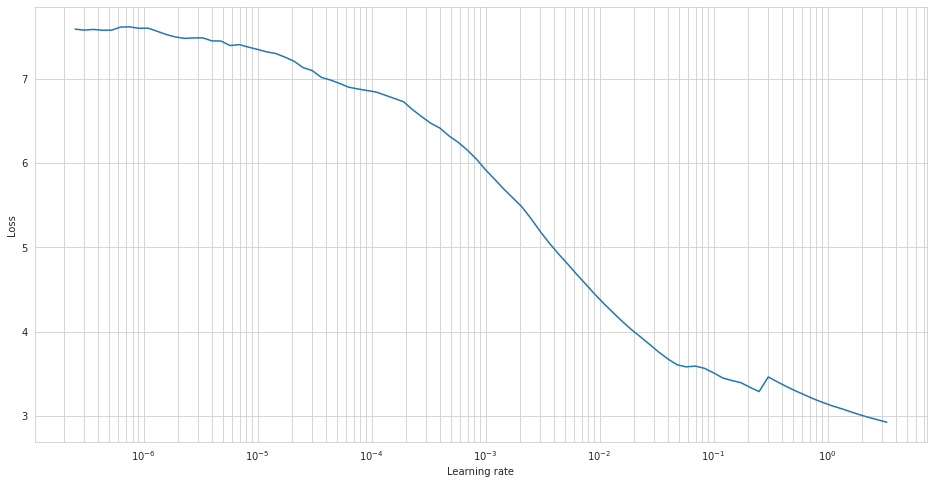

In [ ]:
OUTPUT_DIM = 10

model3 = BaseModel(OUTPUT_DIM) #again, basemodel different batch size

print(f'The model has {count_parameters(model3):,} trainable parameters')

model3.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model3.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model3 = model3.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model3, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model3,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-2

optimizer = optim.Adam(model3.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses3=[]
trainaccuracies3=[]
vallosses3=[]
valaccuracies3=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model3, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model3, valid_iterator, criterion, device)

  trainlosses3.append(np.double(train_loss))
  trainaccuracies3.append(np.double(train_acc*100))
  vallosses3.append(np.double(valid_loss))
  valaccuracies3.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model3.state_dict(), 'model3.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 9.360 | Train Acc: 24.45%
	 Val. Loss: 1.792 |  Val. Acc: 34.91%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.767 | Train Acc: 36.44%
	 Val. Loss: 1.566 |  Val. Acc: 43.67%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 1.618 | Train Acc: 41.05%
	 Val. Loss: 1.430 |  Val. Acc: 48.51%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 1.527 | Train Acc: 44.93%
	 Val. Loss: 1.331 |  Val. Acc: 52.04%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.455 | Train Acc: 47.43%
	 Val. Loss: 1.299 |  Val. Acc: 53.91%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.408 | Train Acc: 49.00%
	 Val. Loss: 1.286 |  Val. Acc: 53.14%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.346 | Train Acc: 51.58%
	 Val. Loss: 1.188 |  Val. Acc: 57.12%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.296 | Train Acc: 53.97%
	 Val. Loss: 1.125 |  Val. Acc: 59.81%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 1.252 | Train Acc: 55.54%
	 Val. Loss: 1.046 |  Val. Acc: 63.21%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 1.204 | Train Acc: 57.46%
	 Val. Loss: 0.986 |  Val. Acc: 64.74%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 21s
	Train Loss: 1.156 | Train Acc: 59.07%
	 Val. Loss: 0.988 |  Val. Acc: 64.26%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 21s
	Train Loss: 1.119 | Train Acc: 60.43%
	 Val. Loss: 0.942 |  Val. Acc: 66.69%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 21s
	Train Loss: 1.067 | Train Acc: 62.78%
	 Val. Loss: 0.885 |  Val. Acc: 69.08%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 21s
	Train Loss: 1.039 | Train Acc: 63.57%
	 Val. Loss: 0.961 |  Val. Acc: 66.57%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 22s
	Train Loss: 1.008 | Train Acc: 64.72%
	 Val. Loss: 0.845 |  Val. Acc: 70.10%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 21s
	Train Loss: 0.980 | Train Acc: 65.80%
	 Val. Loss: 0.815 |  Val. Acc: 70.88%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 21s
	Train Loss: 0.946 | Train Acc: 67.04%
	 Val. Loss: 0.784 |  Val. Acc: 72.42%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 21s
	Train Loss: 0.944 | Train Acc: 67.21%
	 Val. Loss: 0.789 |  Val. Acc: 72.23%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 21s
	Train Loss: 0.922 | Train Acc: 67.86%
	 Val. Loss: 0.756 |  Val. Acc: 73.45%


Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 21s
	Train Loss: 0.886 | Train Acc: 69.16%
	 Val. Loss: 0.765 |  Val. Acc: 72.98%


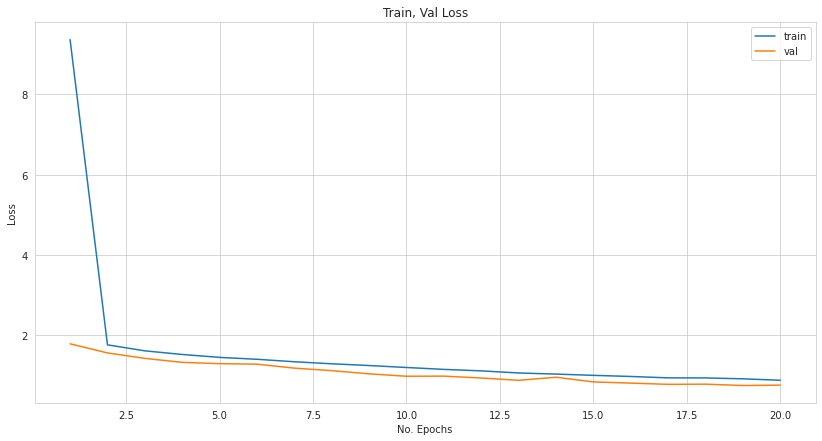

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses3,label='train')
plt.plot(x,vallosses3,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

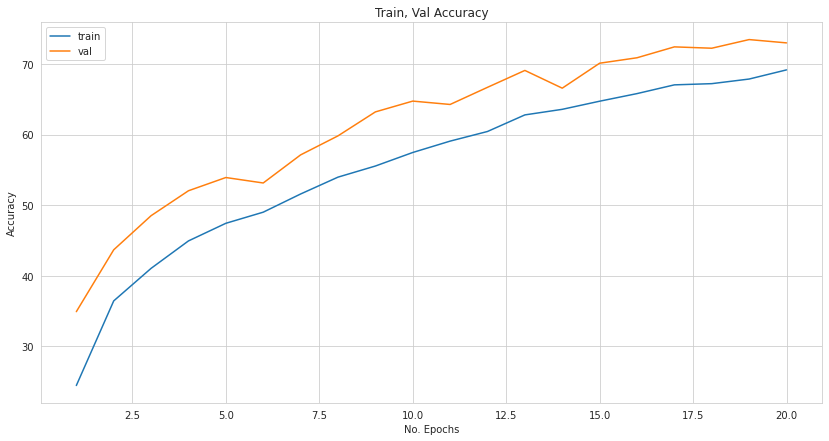

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies3,label='train')
plt.plot(x,valaccuracies3,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

In [ ]:
model3.load_state_dict(torch.load('model3.pt'))

test_loss, test_acc = evaluate(model3, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.772 | Test Acc: 73.51%


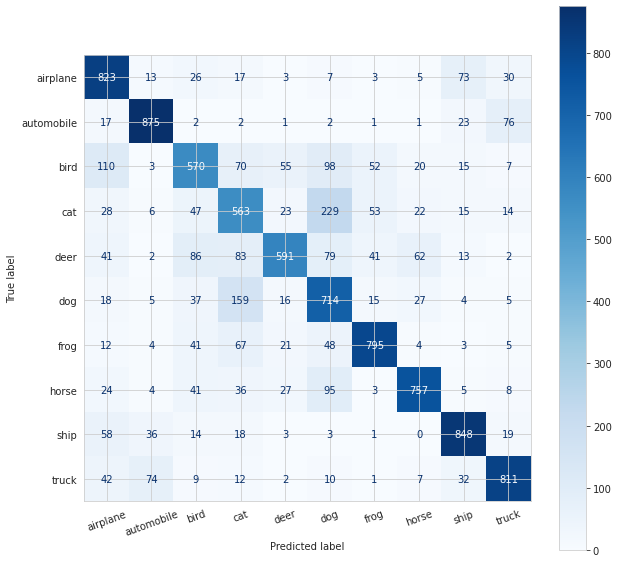

In [ ]:
images, labels, probs = get_predictions(model3, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

**Stochastic Gradient Descent (SGD)**

In [ ]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE) #pin_memory=True

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

The model has 2,159,242 trainable parameters
Stopping early, the loss has diverged


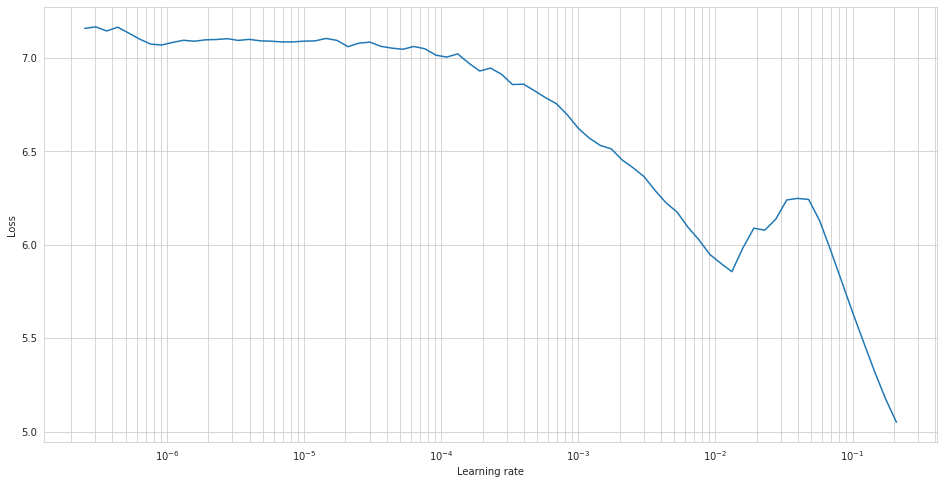

In [ ]:
OUTPUT_DIM = 10

model4 = BaseModel(OUTPUT_DIM) #base model

print(f'The model has {count_parameters(model4):,} trainable parameters')

model4.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.SGD(model4.parameters(), lr=START_LR) #different optimization

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model4 = model4.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model4, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model4,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.SGD(model4.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses4=[]
trainaccuracies4=[]
vallosses4=[]
valaccuracies4=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model4, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model4, valid_iterator, criterion, device)

  trainlosses4.append(np.double(train_loss))
  trainaccuracies4.append(np.double(train_acc*100))
  vallosses4.append(np.double(valid_loss))
  valaccuracies4.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model4.state_dict(), 'model4.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 3.607 | Train Acc: 18.60%
	 Val. Loss: 1.920 |  Val. Acc: 31.52%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 2.478 | Train Acc: 24.13%
	 Val. Loss: 1.801 |  Val. Acc: 34.51%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 2.174 | Train Acc: 26.87%
	 Val. Loss: 1.762 |  Val. Acc: 35.68%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 2.044 | Train Acc: 29.03%
	 Val. Loss: 1.731 |  Val. Acc: 37.60%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.960 | Train Acc: 30.48%
	 Val. Loss: 1.701 |  Val. Acc: 37.99%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.900 | Train Acc: 31.80%
	 Val. Loss: 1.674 |  Val. Acc: 39.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 1.856 | Train Acc: 33.25%
	 Val. Loss: 1.653 |  Val. Acc: 39.34%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 1.818 | Train Acc: 34.05%
	 Val. Loss: 1.625 |  Val. Acc: 40.68%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 1.794 | Train Acc: 34.85%
	 Val. Loss: 1.608 |  Val. Acc: 41.09%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 1.763 | Train Acc: 35.97%
	 Val. Loss: 1.585 |  Val. Acc: 41.62%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 22s
	Train Loss: 1.736 | Train Acc: 36.66%
	 Val. Loss: 1.567 |  Val. Acc: 42.17%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 22s
	Train Loss: 1.717 | Train Acc: 37.51%
	 Val. Loss: 1.548 |  Val. Acc: 42.99%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 22s
	Train Loss: 1.696 | Train Acc: 37.85%
	 Val. Loss: 1.533 |  Val. Acc: 43.46%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 21s
	Train Loss: 1.677 | Train Acc: 38.81%
	 Val. Loss: 1.518 |  Val. Acc: 43.83%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 21s
	Train Loss: 1.664 | Train Acc: 39.09%
	 Val. Loss: 1.504 |  Val. Acc: 44.47%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 21s
	Train Loss: 1.642 | Train Acc: 39.70%
	 Val. Loss: 1.490 |  Val. Acc: 44.63%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 22s
	Train Loss: 1.629 | Train Acc: 40.40%
	 Val. Loss: 1.476 |  Val. Acc: 45.92%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 21s
	Train Loss: 1.620 | Train Acc: 40.69%
	 Val. Loss: 1.470 |  Val. Acc: 45.61%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 22s
	Train Loss: 1.603 | Train Acc: 41.51%
	 Val. Loss: 1.460 |  Val. Acc: 46.00%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 21s
	Train Loss: 1.591 | Train Acc: 41.64%
	 Val. Loss: 1.448 |  Val. Acc: 46.86%


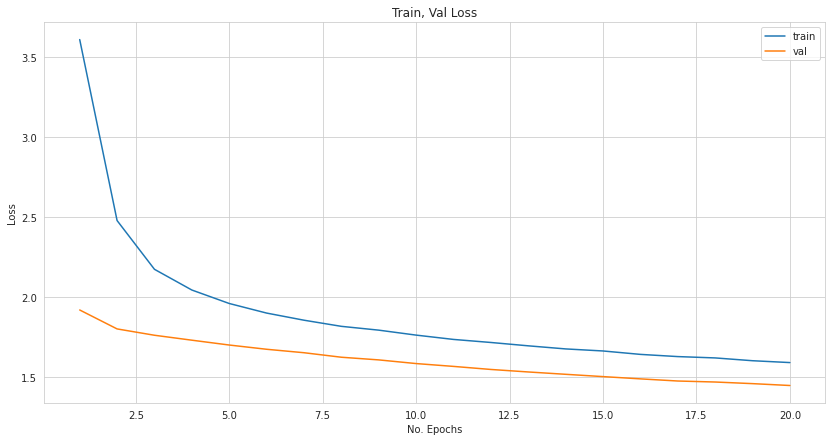

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses4,label='train')
plt.plot(x,vallosses4,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

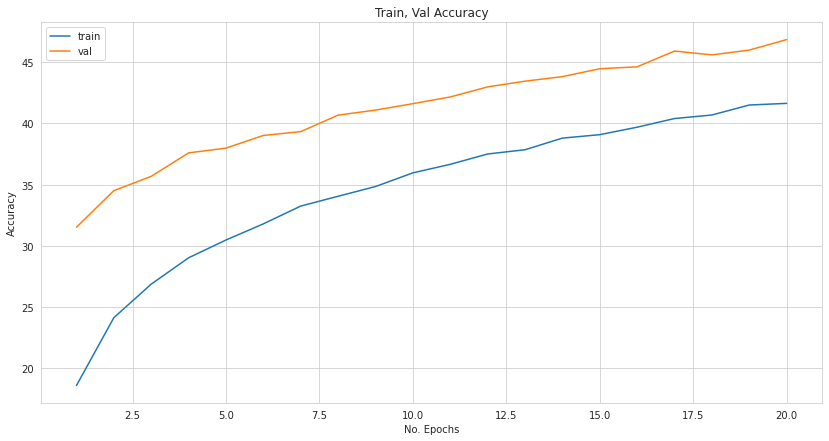

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies4,label='train')
plt.plot(x,valaccuracies4,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

In [ ]:
model4.load_state_dict(torch.load('model4.pt'))

test_loss, test_acc = evaluate(model4, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.444 | Test Acc: 47.43%


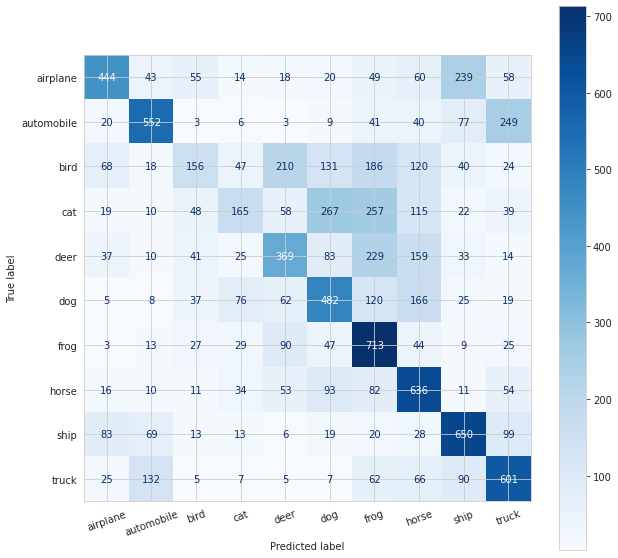

In [ ]:
images, labels, probs = get_predictions(model4, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

The predictions here are just all over the place. Dogs and Frogs being mixed up as cats, Trucks mixed up as automobiles, Ships mixed up as airplanes. This vanilla optimization technique has not improved our model scoring so we will revert back to adam.

**Average Pooling AVGPOOL**

In [ ]:
class ModelAvgPool(nn.Module):
  def __init__(self,output_dim):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1), #input layer
        nn.ReLU(),
        
        nn.Conv2d(32,64,kernel_size=3,padding=1), #first hidden layer
        nn.AvgPool2d(2,2), #64 x 16 x 16
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1), #second hidden layer
        nn.AvgPool2d(2,2), #64 x 8 x 8
        nn.ReLU(),
    )

    self.classifier=nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(64 * 8 * 8, 512), #third hidden layer
        nn.ReLU(),
        nn.Linear(512,output_dim) #output layer

    )

  def forward(self, x):
    x=self.features(x)
    h=x.view(x.shape[0],-1)
    x=self.classifier(h)
    return x,h

The model has 2,159,242 trainable parameters
Stopping early, the loss has diverged


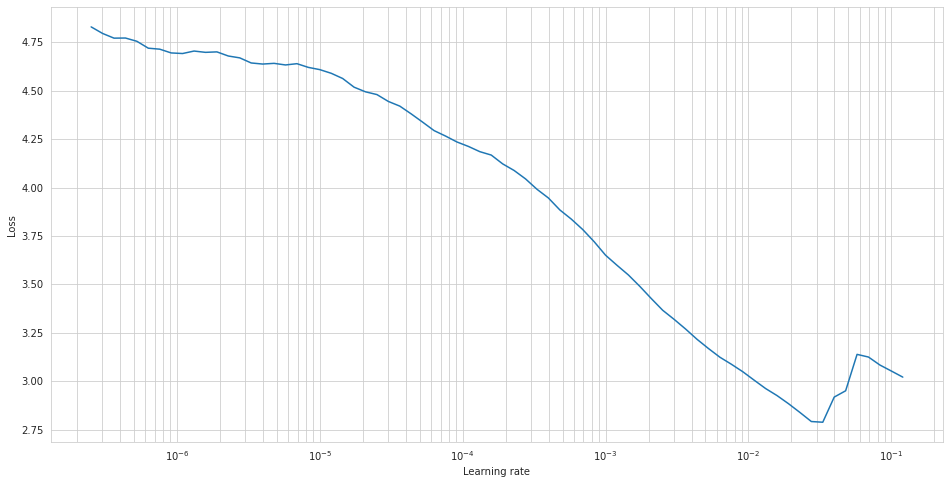

In [ ]:
OUTPUT_DIM = 10

model5 = ModelAvgPool(OUTPUT_DIM)

print(f'The model has {count_parameters(model5):,} trainable parameters')

model5.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model5.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model5 = model5.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model5, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model5,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 5e-3

optimizer = optim.Adam(model5.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses5=[]
trainaccuracies5=[]
vallosses5=[]
valaccuracies5=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model5, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model5, valid_iterator, criterion, device)

  trainlosses5.append(np.double(train_loss))
  trainaccuracies5.append(np.double(train_acc*100))
  vallosses5.append(np.double(valid_loss))
  valaccuracies5.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model5.state_dict(), 'model5.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 2.052 | Train Acc: 36.46%
	 Val. Loss: 1.360 |  Val. Acc: 50.41%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.377 | Train Acc: 50.59%
	 Val. Loss: 1.219 |  Val. Acc: 57.11%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.228 | Train Acc: 56.30%
	 Val. Loss: 1.099 |  Val. Acc: 61.54%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.136 | Train Acc: 59.95%
	 Val. Loss: 0.992 |  Val. Acc: 64.84%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.078 | Train Acc: 62.04%
	 Val. Loss: 0.957 |  Val. Acc: 66.58%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.020 | Train Acc: 64.21%
	 Val. Loss: 0.846 |  Val. Acc: 70.64%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.987 | Train Acc: 65.72%
	 Val. Loss: 0.900 |  Val. Acc: 68.87%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.949 | Train Acc: 66.93%
	 Val. Loss: 0.793 |  Val. Acc: 72.30%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.925 | Train Acc: 67.72%
	 Val. Loss: 0.788 |  Val. Acc: 72.73%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 0.905 | Train Acc: 68.56%
	 Val. Loss: 0.768 |  Val. Acc: 73.20%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 22s
	Train Loss: 0.889 | Train Acc: 69.23%
	 Val. Loss: 0.725 |  Val. Acc: 75.51%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 21s
	Train Loss: 0.867 | Train Acc: 69.86%
	 Val. Loss: 0.714 |  Val. Acc: 75.31%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 22s
	Train Loss: 0.854 | Train Acc: 70.35%
	 Val. Loss: 0.763 |  Val. Acc: 73.96%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 22s
	Train Loss: 0.846 | Train Acc: 70.56%
	 Val. Loss: 0.703 |  Val. Acc: 74.98%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 22s
	Train Loss: 0.832 | Train Acc: 71.25%
	 Val. Loss: 0.751 |  Val. Acc: 74.22%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 22s
	Train Loss: 0.825 | Train Acc: 71.56%
	 Val. Loss: 0.689 |  Val. Acc: 76.48%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 22s
	Train Loss: 0.813 | Train Acc: 71.88%
	 Val. Loss: 0.711 |  Val. Acc: 74.63%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 22s
	Train Loss: 0.814 | Train Acc: 71.82%
	 Val. Loss: 0.751 |  Val. Acc: 73.96%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 22s
	Train Loss: 0.804 | Train Acc: 72.20%
	 Val. Loss: 0.708 |  Val. Acc: 75.78%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 22s
	Train Loss: 0.801 | Train Acc: 72.32%
	 Val. Loss: 0.703 |  Val. Acc: 75.64%


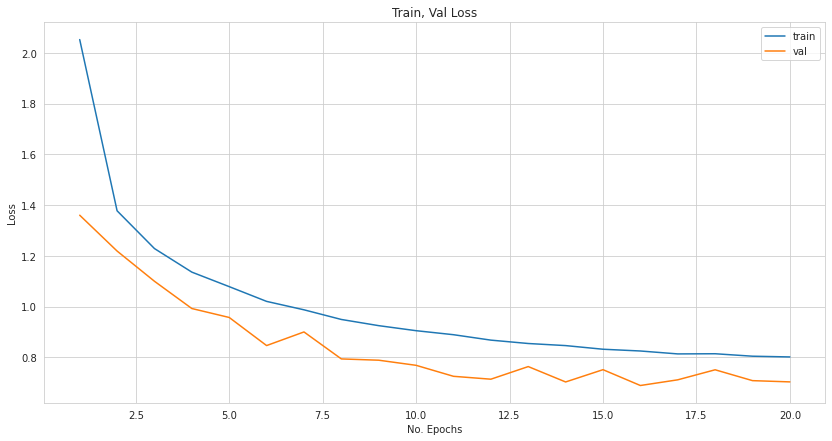

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses5,label='train')
plt.plot(x,vallosses5,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

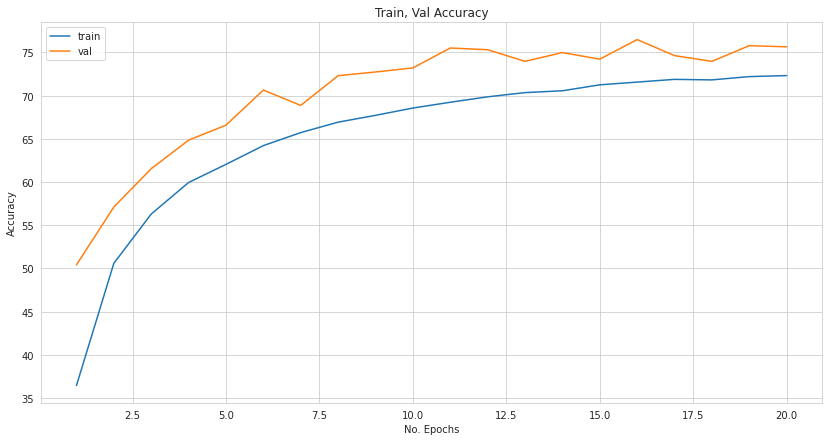

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies5,label='train')
plt.plot(x,valaccuracies5,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

In [ ]:
model5.load_state_dict(torch.load('model5.pt'))

test_loss, test_acc = evaluate(model5, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.694 | Test Acc: 76.54%


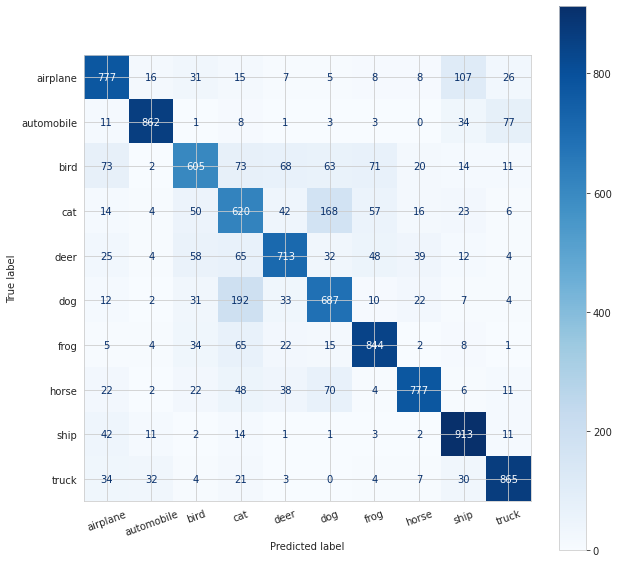

In [ ]:
images, labels, probs = get_predictions(model5, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Slight improvements from our maxpooling basemodel example. Classes that were already being predicted well are doing even better. Yet again, its raining cats and dogs, they're being mixed up!

**WIDER NETWORK**

In [ ]:
class ModelWide(nn.Module):
  def __init__(self,output_dim):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,padding=1), #input layer
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,padding=1), #first hidden layer
        nn.AvgPool2d(2,2), #64 x 16 x 16
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1), #second hidden layer
        nn.AvgPool2d(2,2), #64 x 8 x 8
        nn.ReLU(),
    )

    self.classifier=nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(128 * 8 * 8, 1024), #third hidden layer
        nn.ReLU(),
        nn.Linear(1024,output_dim) #output layer

    )

  def forward(self, x):
    x=self.features(x)
    h=x.view(x.shape[0],-1)
    x=self.classifier(h)
    return x,h

The model has 8,623,370 trainable parameters
Stopping early, the loss has diverged


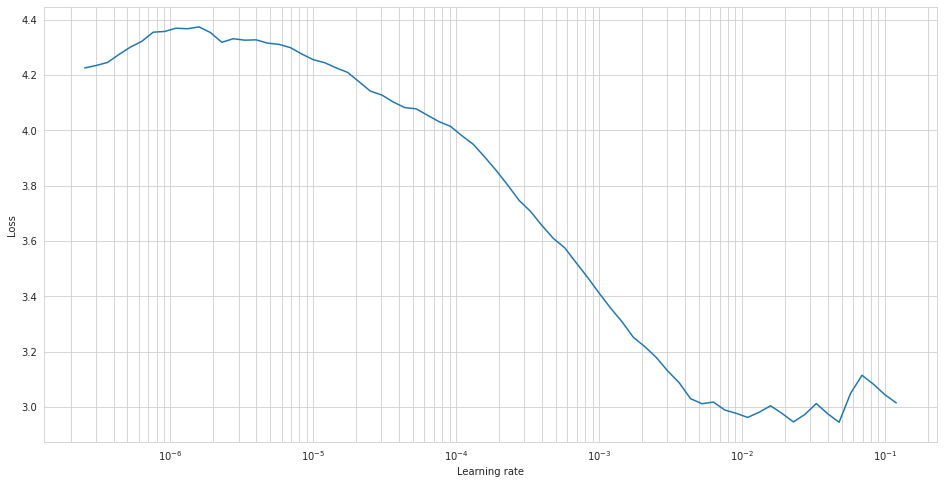

In [ ]:
OUTPUT_DIM = 10

model6 = ModelWide(OUTPUT_DIM)

print(f'The model has {count_parameters(model6):,} trainable parameters')

model6.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model6.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model6 = model6.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model6, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model6,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model6.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses6=[]
trainaccuracies6=[]
vallosses6=[]
valaccuracies6=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model6, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model6, valid_iterator, criterion, device)

  trainlosses6.append(np.double(train_loss))
  trainaccuracies6.append(np.double(train_acc*100))
  vallosses6.append(np.double(valid_loss))
  valaccuracies6.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model6.state_dict(), 'model6.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 1.817 | Train Acc: 42.25%
	 Val. Loss: 1.287 |  Val. Acc: 53.81%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 26s
	Train Loss: 1.229 | Train Acc: 55.58%
	 Val. Loss: 1.068 |  Val. Acc: 62.15%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 1.060 | Train Acc: 62.25%
	 Val. Loss: 0.938 |  Val. Acc: 67.09%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.960 | Train Acc: 66.03%
	 Val. Loss: 0.822 |  Val. Acc: 70.88%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.895 | Train Acc: 68.30%
	 Val. Loss: 0.801 |  Val. Acc: 70.41%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 26s
	Train Loss: 0.848 | Train Acc: 70.24%
	 Val. Loss: 0.739 |  Val. Acc: 73.77%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 27s
	Train Loss: 0.799 | Train Acc: 71.95%
	 Val. Loss: 0.741 |  Val. Acc: 73.55%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 26s
	Train Loss: 0.767 | Train Acc: 73.11%
	 Val. Loss: 0.708 |  Val. Acc: 75.43%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 26s
	Train Loss: 0.746 | Train Acc: 73.73%
	 Val. Loss: 0.647 |  Val. Acc: 76.93%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 26s
	Train Loss: 0.716 | Train Acc: 74.86%
	 Val. Loss: 0.626 |  Val. Acc: 77.50%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 25s
	Train Loss: 0.691 | Train Acc: 75.54%
	 Val. Loss: 0.654 |  Val. Acc: 76.93%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 26s
	Train Loss: 0.672 | Train Acc: 76.45%
	 Val. Loss: 0.607 |  Val. Acc: 78.75%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 26s
	Train Loss: 0.652 | Train Acc: 77.21%
	 Val. Loss: 0.588 |  Val. Acc: 80.18%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 26s
	Train Loss: 0.637 | Train Acc: 77.77%
	 Val. Loss: 0.588 |  Val. Acc: 79.51%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 30s
	Train Loss: 0.618 | Train Acc: 78.34%
	 Val. Loss: 0.571 |  Val. Acc: 80.21%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 26s
	Train Loss: 0.598 | Train Acc: 79.13%
	 Val. Loss: 0.568 |  Val. Acc: 80.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 27s
	Train Loss: 0.596 | Train Acc: 79.18%
	 Val. Loss: 0.572 |  Val. Acc: 79.53%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 26s
	Train Loss: 0.580 | Train Acc: 79.75%
	 Val. Loss: 0.550 |  Val. Acc: 81.13%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 26s
	Train Loss: 0.564 | Train Acc: 80.43%
	 Val. Loss: 0.547 |  Val. Acc: 81.11%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 26s
	Train Loss: 0.551 | Train Acc: 80.61%
	 Val. Loss: 0.549 |  Val. Acc: 80.57%


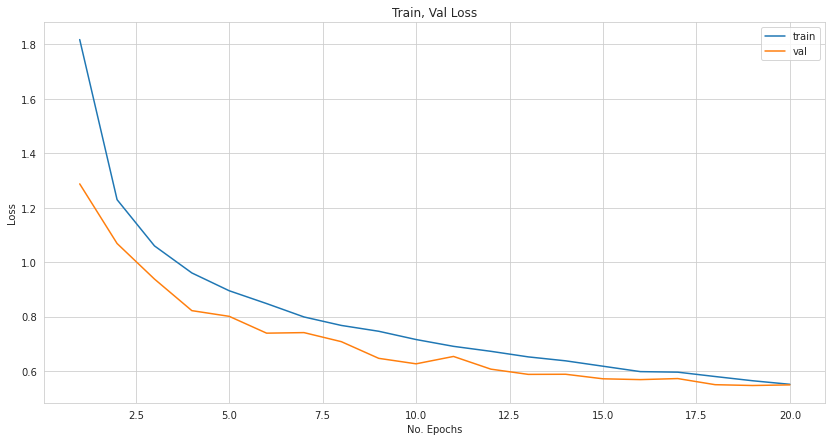

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses6,label='train')
plt.plot(x,vallosses6,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

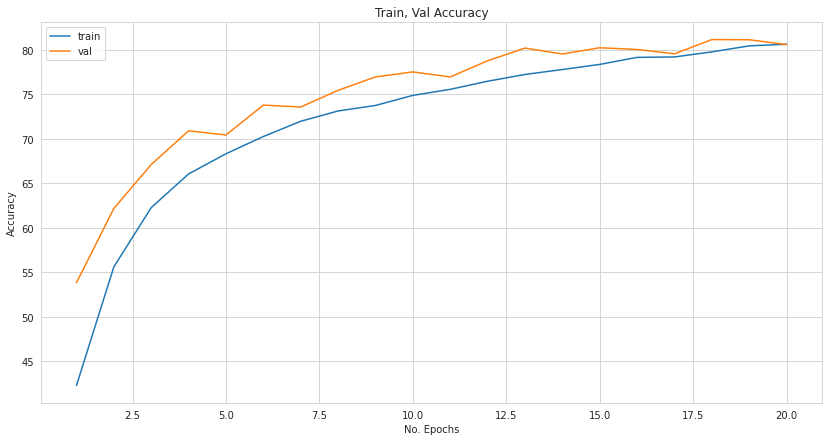

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies6,label='train')
plt.plot(x,valaccuracies6,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

Train and Val accuracies are starting to converge at the tail end of our epochs here, this is something to keep an eye on.

In [ ]:
model6.load_state_dict(torch.load('model6.pt'))

test_loss, test_acc = evaluate(model6, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.561 | Test Acc: 80.68%


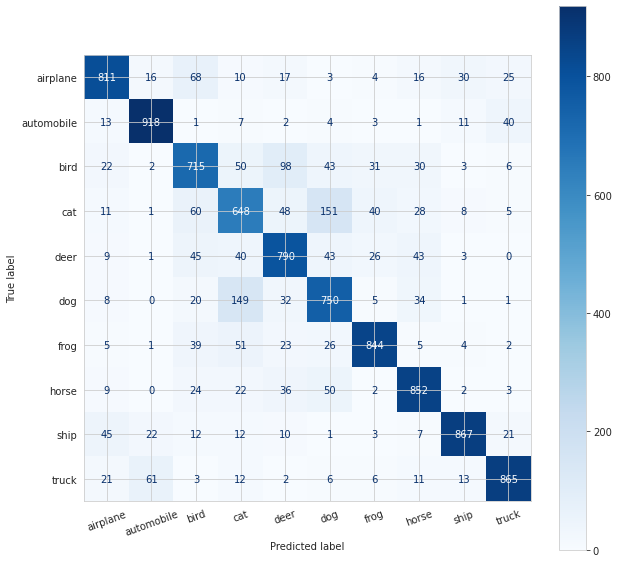

In [ ]:
images, labels, probs = get_predictions(model6, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Accuracy looks great here, small improvements over each class have lead to 80% accuracy on test data. Yet again... cats and dogs.

DEEPER NETWORK

In [ ]:
class ModelDeep(nn.Module):
  def __init__(self,output_dim):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,padding=1), #input layer
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), #first hidden layer
        nn.AvgPool2d(2,2), #64 x 16 x 16
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1), #second hidden layer
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1), #third
        nn.AvgPool2d(2,2),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.classifier=nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(256 * 8 * 8, 2048), #fourth hidden layer
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2048, 1024), #fifth
        nn.ReLU(),
        nn.Linear(1024,output_dim) #output layer

    )

  def forward(self, x):
    x=self.features(x)
    h=x.view(x.shape[0],-1)
    x=self.classifier(h)
    return x,h

The model has 36,626,570 trainable parameters
Stopping early, the loss has diverged


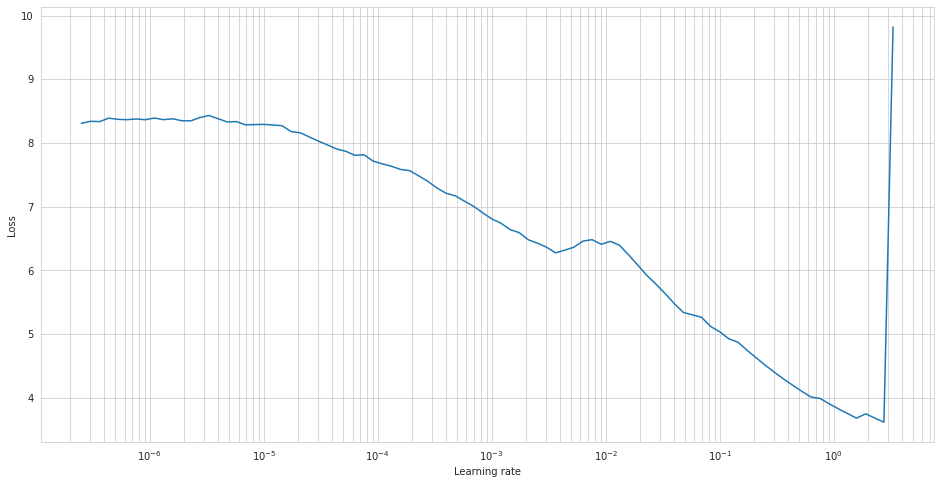

In [ ]:
OUTPUT_DIM = 10

model7 = ModelDeep(OUTPUT_DIM)

print(f'The model has {count_parameters(model7):,} trainable parameters')

model7.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model7.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model7 = model7.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model7, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model7,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model7.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses7=[]
trainaccuracies7=[]
vallosses7=[]
valaccuracies7=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model7, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model7, valid_iterator, criterion, device)

  trainlosses7.append(np.double(train_loss))
  trainaccuracies7.append(np.double(train_acc*100))
  vallosses7.append(np.double(valid_loss))
  valaccuracies7.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model7.state_dict(), 'model7.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 2.205 | Train Acc: 36.12%
	 Val. Loss: 1.366 |  Val. Acc: 50.33%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 1.383 | Train Acc: 49.77%
	 Val. Loss: 1.146 |  Val. Acc: 58.69%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 38s
	Train Loss: 1.196 | Train Acc: 56.80%
	 Val. Loss: 1.053 |  Val. Acc: 62.97%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 38s
	Train Loss: 1.056 | Train Acc: 62.56%
	 Val. Loss: 0.886 |  Val. Acc: 69.02%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 38s
	Train Loss: 0.944 | Train Acc: 66.61%
	 Val. Loss: 0.765 |  Val. Acc: 72.50%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 38s
	Train Loss: 0.863 | Train Acc: 69.84%
	 Val. Loss: 0.717 |  Val. Acc: 74.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 38s
	Train Loss: 0.795 | Train Acc: 72.12%
	 Val. Loss: 0.706 |  Val. Acc: 75.51%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 38s
	Train Loss: 0.752 | Train Acc: 73.75%
	 Val. Loss: 0.750 |  Val. Acc: 73.59%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 38s
	Train Loss: 0.712 | Train Acc: 75.42%
	 Val. Loss: 0.629 |  Val. Acc: 78.55%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 38s
	Train Loss: 0.681 | Train Acc: 76.27%
	 Val. Loss: 0.609 |  Val. Acc: 78.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 39s
	Train Loss: 0.646 | Train Acc: 77.62%
	 Val. Loss: 0.580 |  Val. Acc: 80.31%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 39s
	Train Loss: 0.614 | Train Acc: 78.93%
	 Val. Loss: 0.535 |  Val. Acc: 81.76%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 38s
	Train Loss: 0.589 | Train Acc: 79.44%
	 Val. Loss: 0.542 |  Val. Acc: 81.89%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 38s
	Train Loss: 0.576 | Train Acc: 80.14%
	 Val. Loss: 0.539 |  Val. Acc: 81.46%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 38s
	Train Loss: 0.543 | Train Acc: 81.28%
	 Val. Loss: 0.511 |  Val. Acc: 82.38%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 38s
	Train Loss: 0.516 | Train Acc: 82.03%
	 Val. Loss: 0.523 |  Val. Acc: 81.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 38s
	Train Loss: 0.505 | Train Acc: 82.65%
	 Val. Loss: 0.485 |  Val. Acc: 83.81%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 38s
	Train Loss: 0.478 | Train Acc: 83.50%
	 Val. Loss: 0.470 |  Val. Acc: 83.79%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 38s
	Train Loss: 0.464 | Train Acc: 84.07%
	 Val. Loss: 0.469 |  Val. Acc: 84.20%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 38s
	Train Loss: 0.444 | Train Acc: 84.58%
	 Val. Loss: 0.444 |  Val. Acc: 84.75%


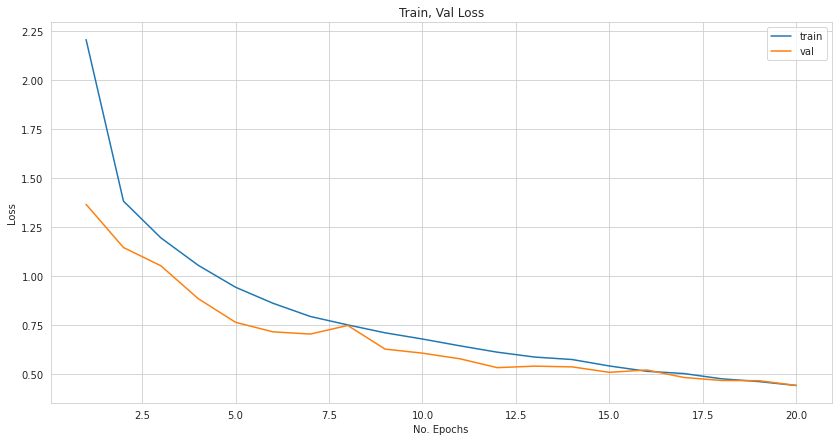

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses7,label='train')
plt.plot(x,vallosses7,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

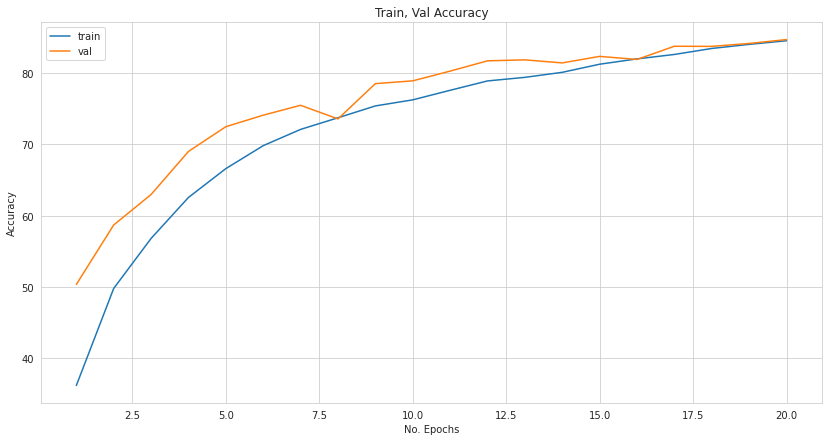

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies7,label='train')
plt.plot(x,valaccuracies7,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

Visually it appears as though training and validation accuracy have fully converged.

In [ ]:
model7.load_state_dict(torch.load('model7.pt'))

test_loss, test_acc = evaluate(model7, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.456 | Test Acc: 85.22%


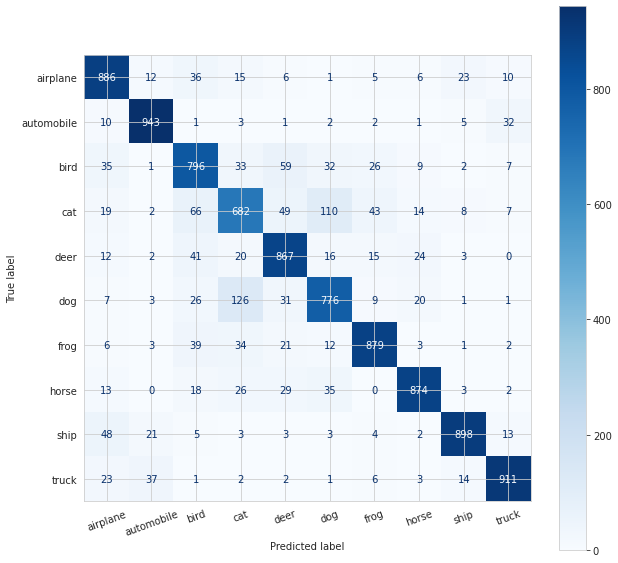

In [ ]:
images, labels, probs = get_predictions(model7, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Model performance here is the best so far. Dark blue on our heatmap denotes high predictability of that class. Now it is only cats and dogs that are underperforming.

**Dropout (0.2)**

In [ ]:
class ModelSmallDropout(nn.Module):
  def __init__(self,output_dim):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,padding=1), #input layer
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), #first hidden layer
        nn.AvgPool2d(2,2), #64 x 16 x 16
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1), #second hidden layer
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1), #third
        nn.AvgPool2d(2,2),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.classifier=nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(256 * 8 * 8, 2048), #fourth hidden layer
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(2048, 1024), #fifth
        nn.ReLU(),
        nn.Linear(1024,output_dim) #output layer

    )

  def forward(self, x):
    x=self.features(x)
    h=x.view(x.shape[0],-1)
    x=self.classifier(h)
    return x,h

The model has 36,626,570 trainable parameters


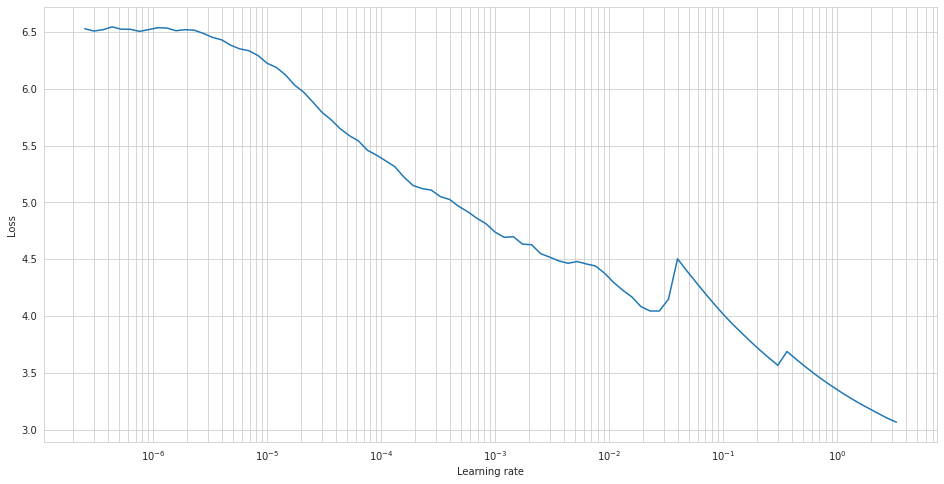

In [ ]:
OUTPUT_DIM = 10

model8 = ModelSmallDropout(OUTPUT_DIM)

print(f'The model has {count_parameters(model8):,} trainable parameters')

model8.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model8.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model8.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model8, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model8,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model8.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses8=[]
trainaccuracies8=[]
vallosses8=[]
valaccuracies8=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model8, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model8, valid_iterator, criterion, device)

  trainlosses8.append(np.double(train_loss))
  trainaccuracies8.append(np.double(train_acc*100))
  vallosses8.append(np.double(valid_loss))
  valaccuracies8.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model8.state_dict(), 'model8.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 1.844 | Train Acc: 43.39%
	 Val. Loss: 1.282 |  Val. Acc: 53.28%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 38s
	Train Loss: 1.172 | Train Acc: 58.17%
	 Val. Loss: 0.961 |  Val. Acc: 65.68%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 38s
	Train Loss: 0.958 | Train Acc: 66.24%
	 Val. Loss: 0.836 |  Val. Acc: 70.96%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 38s
	Train Loss: 0.816 | Train Acc: 71.23%
	 Val. Loss: 0.766 |  Val. Acc: 72.60%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 38s
	Train Loss: 0.729 | Train Acc: 74.46%
	 Val. Loss: 0.646 |  Val. Acc: 76.66%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 38s
	Train Loss: 0.657 | Train Acc: 77.22%
	 Val. Loss: 0.640 |  Val. Acc: 78.18%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 38s
	Train Loss: 0.596 | Train Acc: 79.04%
	 Val. Loss: 0.586 |  Val. Acc: 80.08%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 38s
	Train Loss: 0.544 | Train Acc: 81.13%
	 Val. Loss: 0.624 |  Val. Acc: 79.51%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 38s
	Train Loss: 0.510 | Train Acc: 82.22%
	 Val. Loss: 0.583 |  Val. Acc: 80.59%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 37s
	Train Loss: 0.474 | Train Acc: 83.31%
	 Val. Loss: 0.595 |  Val. Acc: 80.23%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 38s
	Train Loss: 0.442 | Train Acc: 84.66%
	 Val. Loss: 0.572 |  Val. Acc: 82.03%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 39s
	Train Loss: 0.408 | Train Acc: 85.87%
	 Val. Loss: 0.564 |  Val. Acc: 81.60%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 39s
	Train Loss: 0.385 | Train Acc: 86.71%
	 Val. Loss: 0.538 |  Val. Acc: 82.58%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 38s
	Train Loss: 0.366 | Train Acc: 87.30%
	 Val. Loss: 0.569 |  Val. Acc: 82.89%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 38s
	Train Loss: 0.338 | Train Acc: 88.26%
	 Val. Loss: 0.521 |  Val. Acc: 84.06%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 37s
	Train Loss: 0.315 | Train Acc: 88.91%
	 Val. Loss: 0.555 |  Val. Acc: 83.22%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 37s
	Train Loss: 0.300 | Train Acc: 89.68%
	 Val. Loss: 0.527 |  Val. Acc: 83.96%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 38s
	Train Loss: 0.289 | Train Acc: 90.12%
	 Val. Loss: 0.517 |  Val. Acc: 84.86%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 38s
	Train Loss: 0.264 | Train Acc: 90.96%
	 Val. Loss: 0.525 |  Val. Acc: 84.94%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 38s
	Train Loss: 0.251 | Train Acc: 91.30%
	 Val. Loss: 0.536 |  Val. Acc: 84.75%


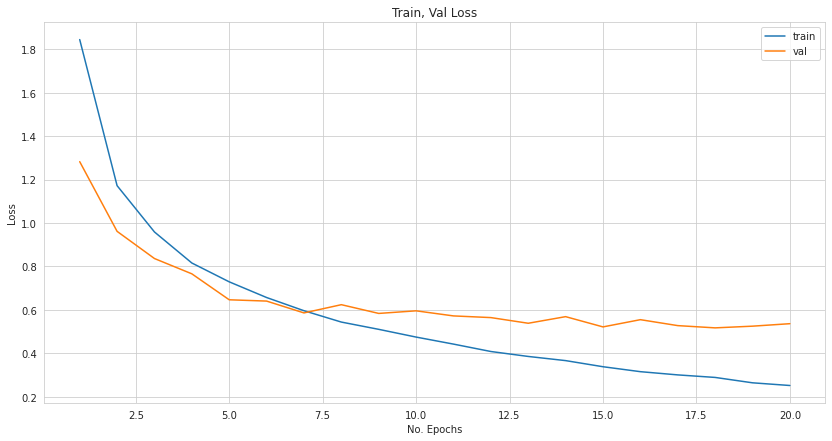

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses8,label='train')
plt.plot(x,vallosses8,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

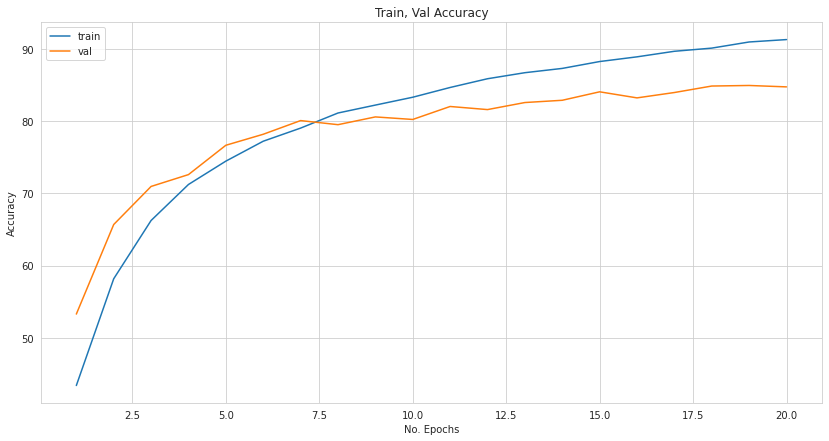

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies8,label='train')
plt.plot(x,valaccuracies8,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

Dropout of 0.2 here is used to illustrate overfitting. As less neurons are dropped more information filters through to our fully connected layers. These layers become too good at predicting training data and cannot generalise to validation data.

In [ ]:
model8.load_state_dict(torch.load('model8.pt'))

test_loss, test_acc = evaluate(model8, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.537 | Test Acc: 84.04%


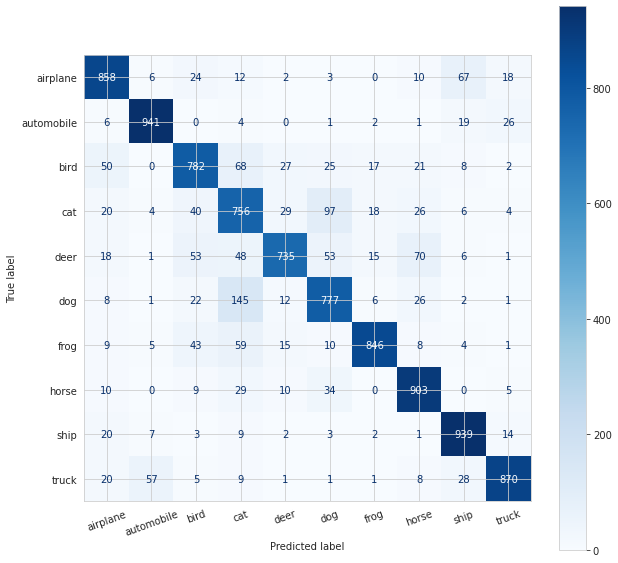

In [ ]:
images, labels, probs = get_predictions(model8, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Still a very strong score here, slightly worse than our dropout of 0.5 but noteworthy.

**DROPOUT(0.8)**

In [ ]:
class ModelBigDropout(nn.Module):
  def __init__(self,output_dim):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,padding=1), #input layer
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1), #first hidden layer
        nn.AvgPool2d(2,2), #64 x 16 x 16
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1), #second hidden layer
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1), #third
        nn.AvgPool2d(2,2),
        nn.ReLU(),
        nn.BatchNorm2d(256)
    )

    self.classifier=nn.Sequential(
        # nn.Flatten(),
        nn.Dropout(0.8),
        nn.Linear(256 * 8 * 8, 2048), #fourth hidden layer
        nn.ReLU(),
        nn.Dropout(0.8),
        nn.Linear(2048, 1024), #fifth
        nn.ReLU(),
        nn.Linear(1024,output_dim) #output layer

    )

  def forward(self, x):
    x=self.features(x)
    h=x.view(x.shape[0],-1)
    x=self.classifier(h)
    return x,h

The model has 2,159,242 trainable parameters


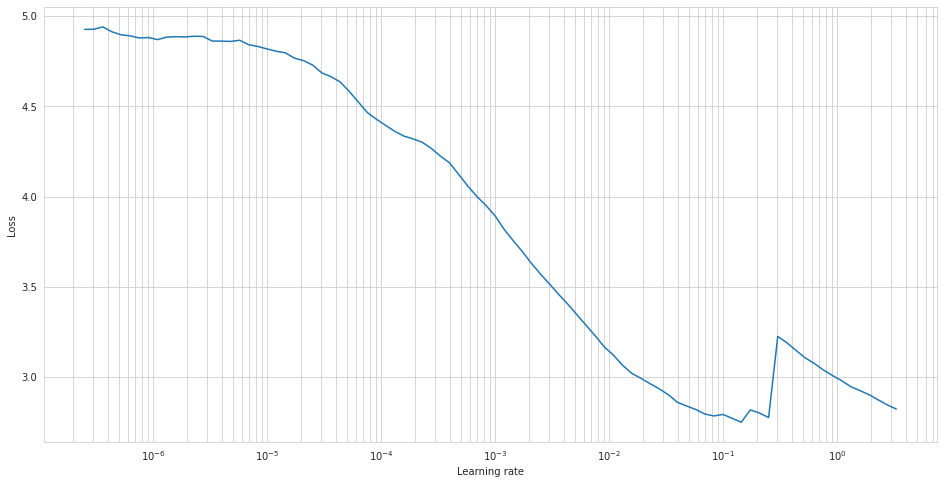

In [ ]:
OUTPUT_DIM = 10

model9 = ModelAvgPool(OUTPUT_DIM)

print(f'The model has {count_parameters(model9):,} trainable parameters')

model9.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model9.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model9.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model9, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model9,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model9.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses9=[]
trainaccuracies9=[]
vallosses9=[]
valaccuracies9=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model9, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model9, valid_iterator, criterion, device)

  trainlosses9.append(np.double(train_loss))
  trainaccuracies9.append(np.double(train_acc*100))
  vallosses9.append(np.double(valid_loss))
  valaccuracies9.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model9.state_dict(), 'model9.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 1.685 | Train Acc: 41.87%
	 Val. Loss: 1.262 |  Val. Acc: 54.49%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.293 | Train Acc: 53.50%
	 Val. Loss: 1.106 |  Val. Acc: 60.33%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 1.145 | Train Acc: 59.09%
	 Val. Loss: 0.958 |  Val. Acc: 66.07%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 1.030 | Train Acc: 63.16%
	 Val. Loss: 0.908 |  Val. Acc: 67.70%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 0.964 | Train Acc: 65.70%
	 Val. Loss: 0.871 |  Val. Acc: 68.52%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.911 | Train Acc: 67.71%
	 Val. Loss: 0.767 |  Val. Acc: 72.54%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 26s
	Train Loss: 0.869 | Train Acc: 69.38%
	 Val. Loss: 0.775 |  Val. Acc: 72.09%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 0.843 | Train Acc: 70.32%
	 Val. Loss: 0.739 |  Val. Acc: 73.75%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 0.815 | Train Acc: 71.30%
	 Val. Loss: 0.709 |  Val. Acc: 74.79%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 0.787 | Train Acc: 72.19%
	 Val. Loss: 0.705 |  Val. Acc: 74.77%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 21s
	Train Loss: 0.761 | Train Acc: 73.25%
	 Val. Loss: 0.689 |  Val. Acc: 76.19%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 21s
	Train Loss: 0.743 | Train Acc: 73.82%
	 Val. Loss: 0.655 |  Val. Acc: 76.64%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 21s
	Train Loss: 0.725 | Train Acc: 74.51%
	 Val. Loss: 0.654 |  Val. Acc: 76.74%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 21s
	Train Loss: 0.718 | Train Acc: 74.73%
	 Val. Loss: 0.654 |  Val. Acc: 76.54%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 21s
	Train Loss: 0.698 | Train Acc: 75.45%
	 Val. Loss: 0.647 |  Val. Acc: 76.86%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 21s
	Train Loss: 0.683 | Train Acc: 76.02%
	 Val. Loss: 0.604 |  Val. Acc: 78.69%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 21s
	Train Loss: 0.676 | Train Acc: 76.18%
	 Val. Loss: 0.631 |  Val. Acc: 77.71%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 22s
	Train Loss: 0.653 | Train Acc: 77.01%
	 Val. Loss: 0.615 |  Val. Acc: 78.32%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 22s
	Train Loss: 0.648 | Train Acc: 77.04%
	 Val. Loss: 0.633 |  Val. Acc: 78.20%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 22s
	Train Loss: 0.639 | Train Acc: 77.60%
	 Val. Loss: 0.593 |  Val. Acc: 79.79%


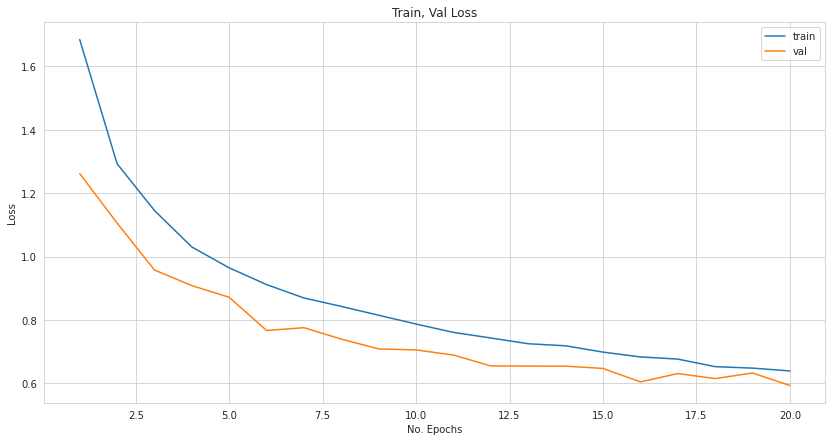

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses9,label='train')
plt.plot(x,vallosses9,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

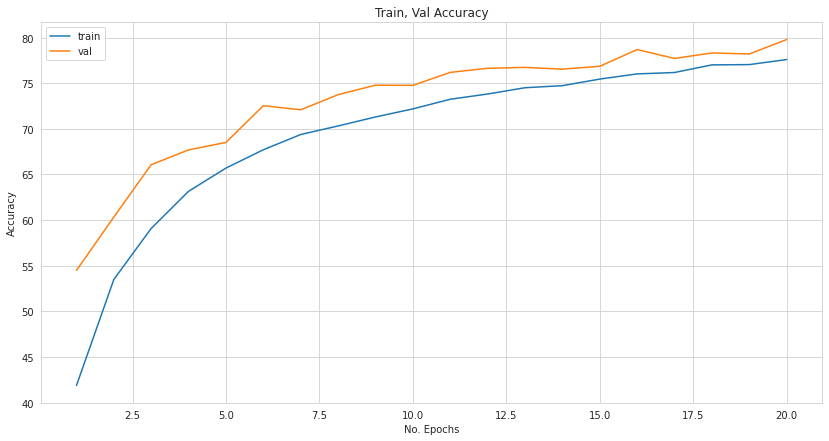

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies9,label='train')
plt.plot(x,valaccuracies9,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

In [ ]:
model9.load_state_dict(torch.load('model9.pt'))

test_loss, test_acc = evaluate(model9, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.607 | Test Acc: 78.57%


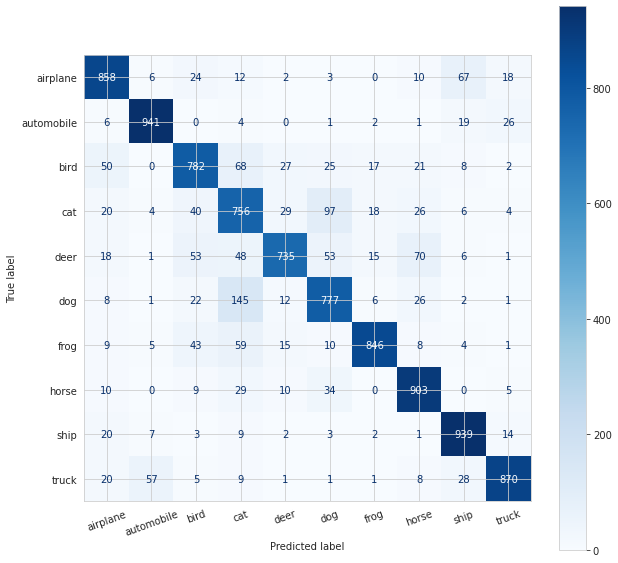

In [ ]:
images, labels, probs = get_predictions(model8, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Increasing the dropout too much doesn't let enough information through. Because of this, vital information was lost that could've been used to predict test labels. Accuracy is still high but is lower than the same deep model that uses lower dropout rates. This is the tradeoff of dropout - to reduce overfitting without eliminating useful feature data.

**AlexNet**

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

The model has 23,272,266 trainable parameters
Stopping early, the loss has diverged


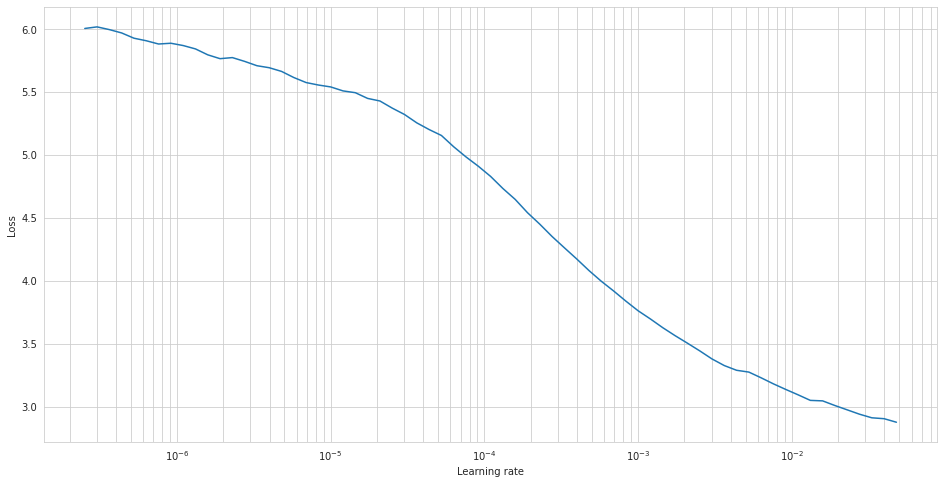

In [ ]:
OUTPUT_DIM = 10

model10 = AlexNet(OUTPUT_DIM)

print(f'The model has {count_parameters(model10):,} trainable parameters')

model10.apply(initialize_parameters)

START_LR = 1e-7

optimizer = optim.Adam(model10.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model10 = model10.to(device)
criterion = criterion.to(device)

END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model10, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(model10,train_iterator, END_LR, NUM_ITER)

plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3

optimizer = optim.Adam(model10.parameters(), lr=FOUND_LR)

In [ ]:
EPOCHS = 20

best_valid_loss = float('inf')

trainlosses10=[]
trainaccuracies10=[]
vallosses10=[]
valaccuracies10=[]

for epoch in trange(EPOCHS, desc="Epochs"):

  start_time = time.monotonic()

  train_loss, train_acc = train(model10, train_iterator, optimizer, criterion, device)

  valid_loss, valid_acc= evaluate(model10, valid_iterator, criterion, device)

  trainlosses10.append(np.double(train_loss))
  trainaccuracies10.append(np.double(train_acc*100))
  vallosses10.append(np.double(valid_loss))
  valaccuracies10.append(np.double(valid_acc*100))

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model10.state_dict(), 'model10.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.972 | Train Acc: 31.37%
	 Val. Loss: 1.604 |  Val. Acc: 40.88%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.442 | Train Acc: 47.12%
	 Val. Loss: 1.267 |  Val. Acc: 53.73%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.300 | Train Acc: 53.11%
	 Val. Loss: 1.169 |  Val. Acc: 57.21%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.201 | Train Acc: 57.48%
	 Val. Loss: 1.078 |  Val. Acc: 61.52%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.131 | Train Acc: 60.16%
	 Val. Loss: 1.035 |  Val. Acc: 63.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.073 | Train Acc: 62.30%
	 Val. Loss: 0.975 |  Val. Acc: 65.57%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 1.018 | Train Acc: 64.56%
	 Val. Loss: 0.936 |  Val. Acc: 66.84%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.970 | Train Acc: 66.53%
	 Val. Loss: 0.929 |  Val. Acc: 67.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.938 | Train Acc: 67.75%
	 Val. Loss: 0.849 |  Val. Acc: 69.84%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 0.900 | Train Acc: 69.00%
	 Val. Loss: 0.870 |  Val. Acc: 70.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 24s
	Train Loss: 0.870 | Train Acc: 70.26%
	 Val. Loss: 0.798 |  Val. Acc: 72.83%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 23s
	Train Loss: 0.842 | Train Acc: 71.28%
	 Val. Loss: 0.818 |  Val. Acc: 71.31%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.821 | Train Acc: 71.58%
	 Val. Loss: 0.773 |  Val. Acc: 72.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 23s
	Train Loss: 0.802 | Train Acc: 72.75%
	 Val. Loss: 0.772 |  Val. Acc: 73.73%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 23s
	Train Loss: 0.777 | Train Acc: 73.74%
	 Val. Loss: 0.787 |  Val. Acc: 73.16%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 24s
	Train Loss: 0.763 | Train Acc: 73.92%
	 Val. Loss: 0.751 |  Val. Acc: 73.54%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 24s
	Train Loss: 0.747 | Train Acc: 74.80%
	 Val. Loss: 0.721 |  Val. Acc: 75.53%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 23s
	Train Loss: 0.728 | Train Acc: 75.24%
	 Val. Loss: 0.732 |  Val. Acc: 74.61%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 24s
	Train Loss: 0.709 | Train Acc: 75.81%
	 Val. Loss: 0.718 |  Val. Acc: 75.27%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 24s
	Train Loss: 0.696 | Train Acc: 76.22%
	 Val. Loss: 0.717 |  Val. Acc: 75.06%


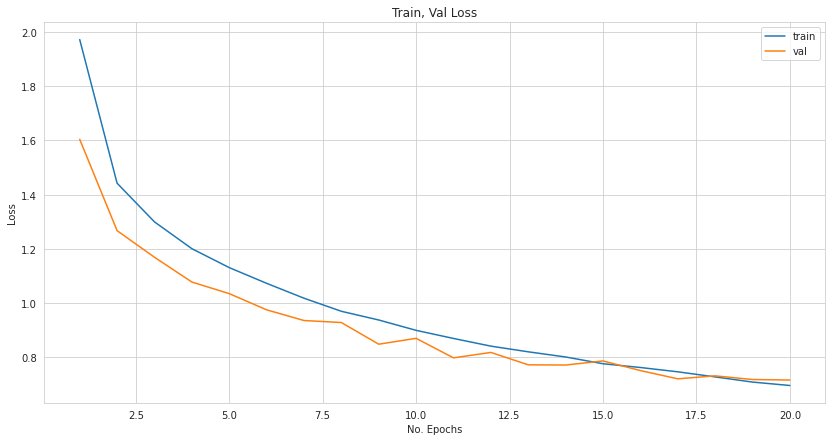

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainlosses10,label='train')
plt.plot(x,vallosses10,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()

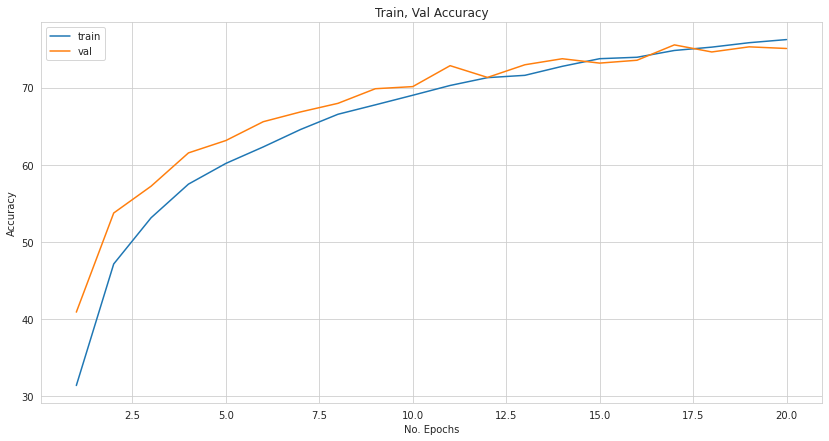

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,trainaccuracies10,label='train')
plt.plot(x,valaccuracies10,label='val')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()

In [ ]:
model10.load_state_dict(torch.load('model10.pt'))

test_loss, test_acc = evaluate(model10, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.733 | Test Acc: 74.97%


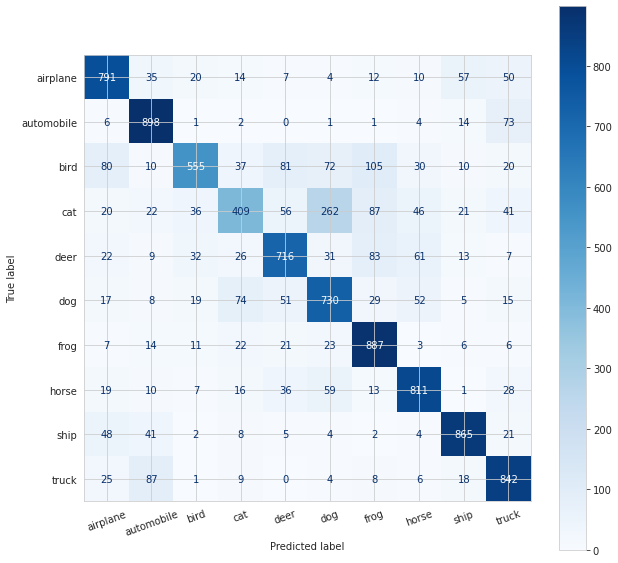

In [ ]:
images, labels, probs = get_predictions(model10, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels, classes)

Interestingly, alexnet has performed well on dogs but very poorly on cats. It learned features that were specific to dogs but then generalised these same features to cats also. Birds were also a poor class for prediction accuracy. The bird predictions differ to cats in that there is a more even distribution of other classes that it tried to predict. 

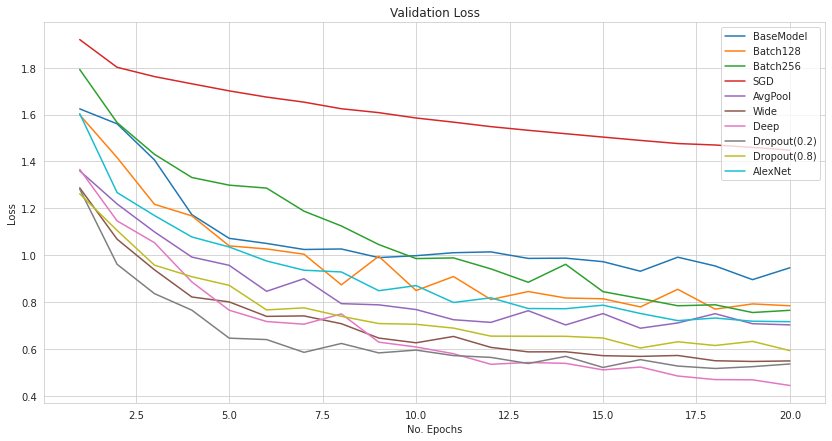

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,vallosses1,label='BaseModel')
plt.plot(x,vallosses2,label='Batch128')
plt.plot(x,vallosses3,label='Batch256')
plt.plot(x,vallosses4,label='SGD')
plt.plot(x,vallosses5,label='AvgPool')
plt.plot(x,vallosses6,label='Wide')
plt.plot(x,vallosses7,label='Deep')
plt.plot(x,vallosses8,label='Dropout(0.2)')
plt.plot(x,vallosses9,label='Dropout(0.8)')
plt.plot(x,vallosses10,label='AlexNet')
plt.xlabel("No. Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

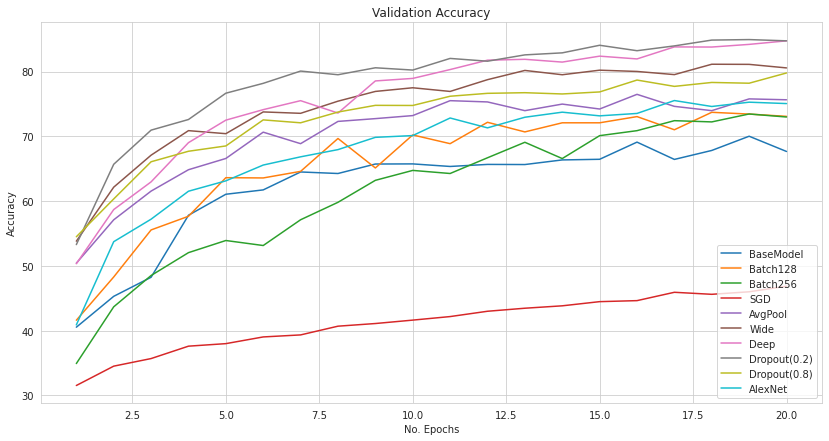

In [ ]:
x = np.array(range(1,21))

plt.figure(figsize=(14,7))
plt.plot(x,valaccuracies1,label='BaseModel')
plt.plot(x,valaccuracies2,label='Batch128')
plt.plot(x,valaccuracies3,label='Batch256')
plt.plot(x,valaccuracies4,label='SGD')
plt.plot(x,valaccuracies5,label='AvgPool')
plt.plot(x,valaccuracies6,label='Wide')
plt.plot(x,valaccuracies7,label='Deep')
plt.plot(x,valaccuracies8,label='Dropout(0.2)')
plt.plot(x,valaccuracies9,label='Dropout(0.8)')
plt.plot(x,valaccuracies10,label='AlexNet')
plt.xlabel("No. Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

The code used in this notebook was found in the link below. This github explores different CNN models for different datasets. There are two tutorials for CIFAR10, one employs AlexNet model and is about 8000 lines. Much of the code they used to explore the data was omitted from my notebook as it was unnecessary to the task. That being said reading through those notebooks gave me much insight into the task being conducted. The data visualisation functions they use include plotting filter transformations and pooling transformations. This immediately helped me understand how both average pooling and max pooling work by seeing their transformed image pairs. They also perform principle components analysis and t-distributed stochastic neighbor embedding on model image outputs to visualise the high domensional data we're looking at. Not only is the code readable but the data visualisation allows for a deeper understanding of different hyperparameters and their effects. I changed the LRFinder class so that the range_test function also included a model parameter which allowed the class to be reused within the same notebook. Previously their implementation did not include this but each notebook only ran one model. I also added extra line plots to visualise my results and wrote my own model architectures to explore the effects of different hyperparameter configurations.

https://github.com/bentrevett/pytorch-image-classification/blob/master/misc/4%20-%20VGG.ipynb [accessed 11/05/2022]

This github was another I considered altering and implementing. It is very nicely organised, models are placed in their own folders and inheritence is used to call on them. The mere 85% accuracy I achieved is a farcry from the 95% they attained. Still, exploring some more advanced CNN architectures was interesting even if I didn't implement them here (there's always next time).

https://github.com/kuangliu/pytorch-cifar [accessed 11/05/2022]

Even PyTorch provides a simple tutorial for building a network on our CIFAR-10 dataset.

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html [accessed 11/05/2022]

I did also start to explore the use of Keras for this task as an alternative which is quite beginner friendly. In the end I chose PyTorch as it provides more line-by-line representations of backpropagation methods which helped me to understand more deeply how these models work. 

https://keras.io/api/datasets/cifar10/ [accessed 11/05/2022]

https://github.com/Ermlab/cifar-keras-tutorial [acessed 11/05/2022]